#### Imports

In [2]:
import sys
import os
import os.path

import numpy as np
import skimage.io
import glob

import shutil
#from config import config_vars

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import skimage.morphology

import tensorflow as tf
import keras

import utils.metrics
import utils.model_builder
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
import seaborn as sb

In [4]:
import skimage.morphology
import skimage.segmentation

import utils.evaluation

#### Prerequisites
> First step is to convert from C01 to tiff using "convert-images-to-tiff-updated.ipynb"
> 
> Put the tiff-files in a directory and change the paths below

#### Convert from tiff to png + normalize 

In [58]:
flist = sorted(os.listdir('/home/jupyter/aitslab_images'))

fdir = '/home/jupyter/aitslab_images/'

# run over all raw images
for filename in tqdm(flist):
    if filename != ".ipynb_checkpoints" and filename != "norm_images" and filename != "boundary_labels":
        

        # load image and its annotation
        orig_img = skimage.io.imread(fdir + filename, plugin='matplotlib')       

        # IMAGE

        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(fdir + "/norm_images/" + filename[:-4] + 'png', img)    


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


#### View result:

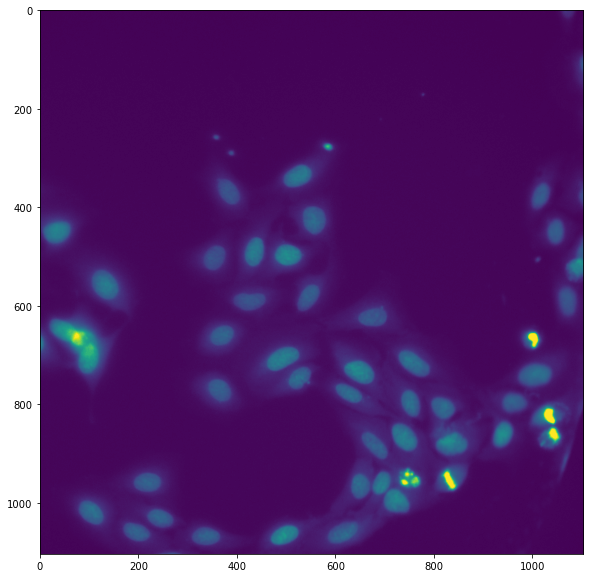

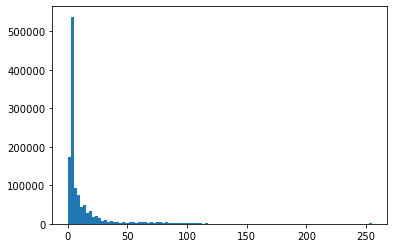

uint8 (1104, 1104)


In [59]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')

img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
plt.hist(img.flatten(), bins=100)
plt.show()
print(img.dtype, img.shape)

#### Compare to BBBC images

In [4]:
from config import config_vars


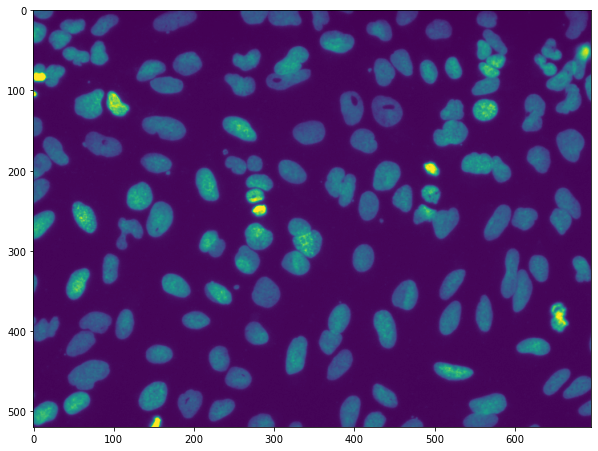

uint8 (520, 696)


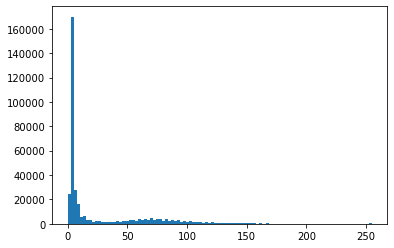

In [7]:
filename = os.listdir(config_vars["normalized_images_dir"])
img = skimage.io.imread(config_vars["normalized_images_dir"] + filename[-1])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
print(img.dtype, img.shape)
plt.hist(img.flatten(), bins=100)
plt.show()

### Make predictions on images from Aitslab

#### Config

In [ ]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'aits2' #convert to 520x696 (same as BBBC)

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

In [4]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

#### preprocess images and load model

In [2]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')

In [35]:
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
images2 = list()
for i in images:
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    images2.append(i)


dim1 = images2.shape[1]
dim2 = images2.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images2 = images2.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images2 = images2 / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images2, batch_size=1)

#model.summary()

#### Plot prob map, predictions and labels

In [ ]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

### Comparison between ground truth and prediction for different images scales

##### Without reshaping images (1104x1104)

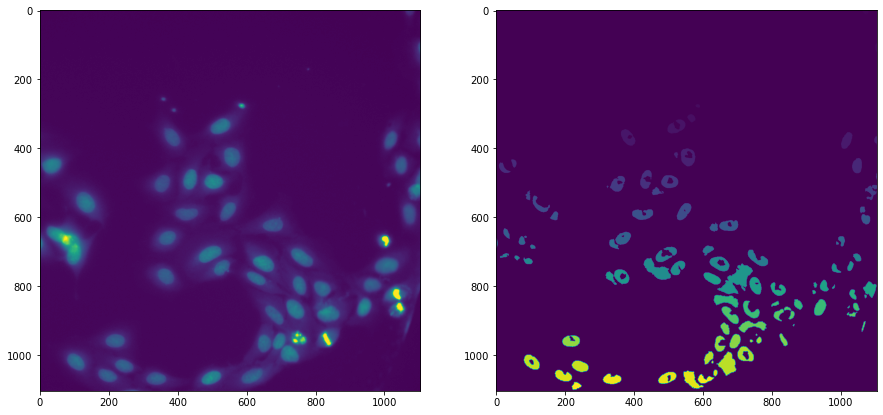

In [37]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

filename2 = os.listdir('/home/jupyter/experiments/aits/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


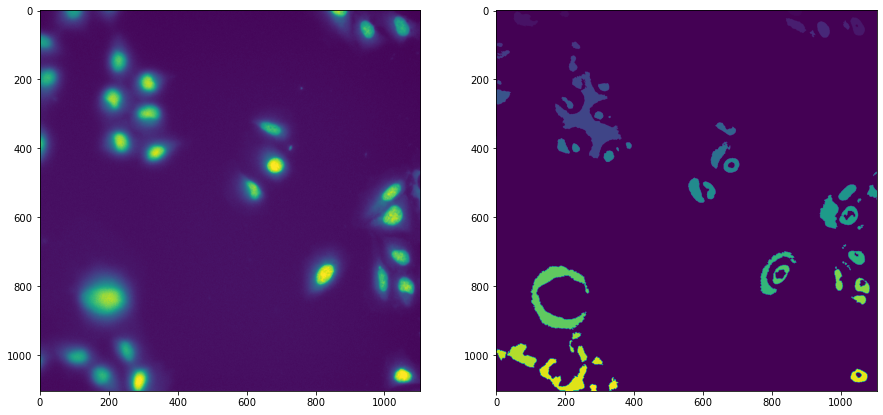

In [40]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

filename2 = os.listdir('/home/jupyter/experiments/aits/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


#### Converting images to same shape as bbbc-images (520x696):

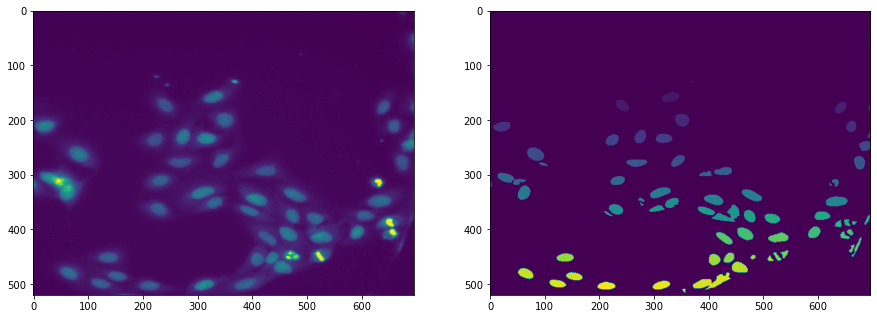

In [44]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

img = resize(img, (520, 696), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits2/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


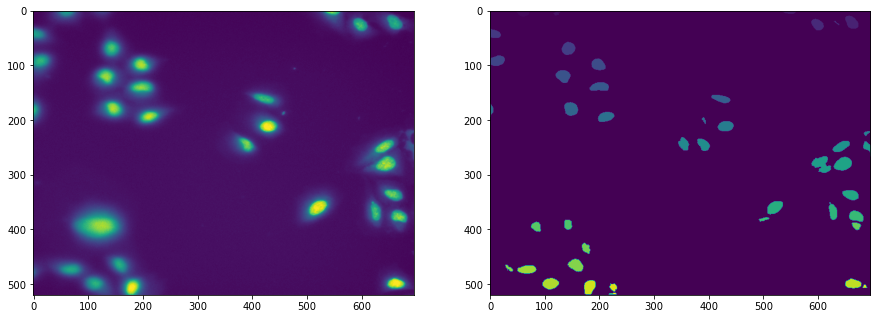

In [45]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

img = resize(img, (520, 696), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits2/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


##### Comparison between real, otsu's and current model prediction

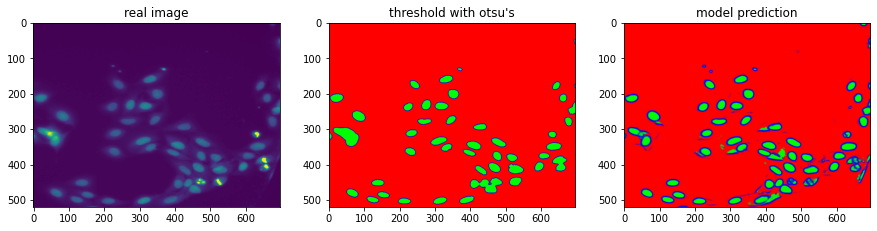

In [17]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits2/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[-1])

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title("real image")
plt.imshow(img)
plt.subplot(132)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(133)
plt.title("model prediction")
plt.imshow(i2)
plt.savefig("comp.png")

#### Reshaping to 256x256

In [ ]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'aits3' #converted to 256x256

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

In [50]:
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
images2 = list()
for i in images:
    i = resize(i, (256, 256), mode='constant', preserve_range=True)
    images2.append(i)
images2 = np.asarray(images2)



dim1 = images2.shape[1]
dim2 = images2.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images2 = images2.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images2 = images2 / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images2, batch_size=1)

#model.summary()

In [ ]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

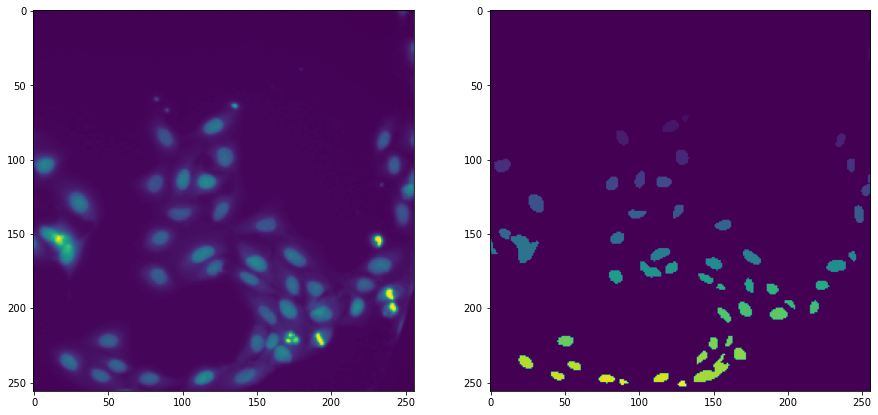

In [53]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

img = resize(img, (256, 256), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits3/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits3/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


In [55]:
#TODO: plot these next to each other

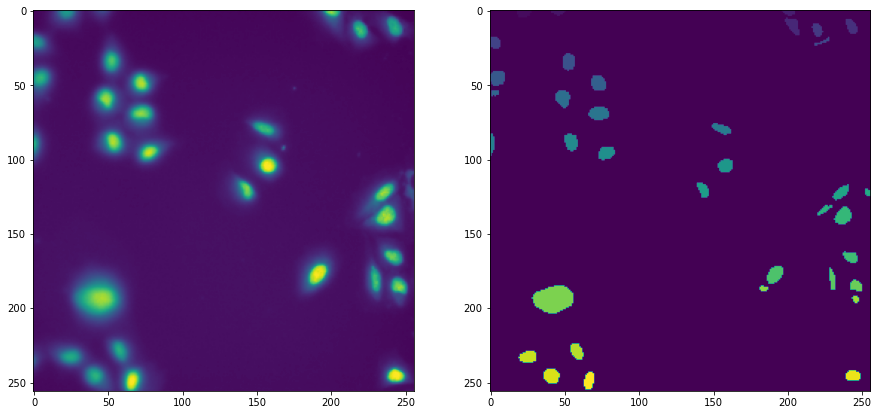

In [60]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

img = resize(img, (256, 256), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits3/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits3/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


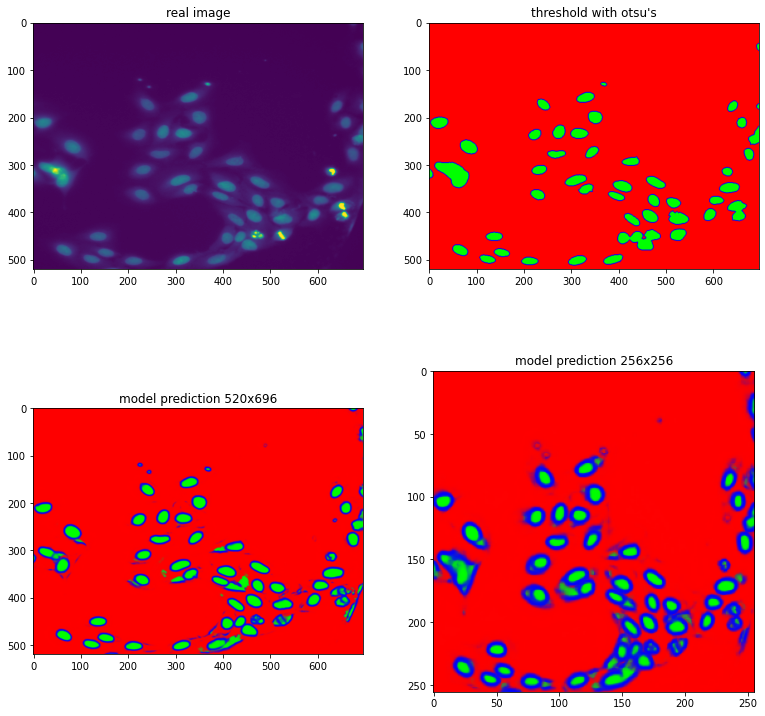

In [2]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[-1])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[-1])

plt.figure(figsize=(13,13))
plt.subplot(221)
plt.title("real image")
plt.imshow(img)
plt.subplot(222)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(223)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.subplot(224)
plt.title("model prediction 256x256")
plt.imshow(i3)
#plt.savefig("comp.png")

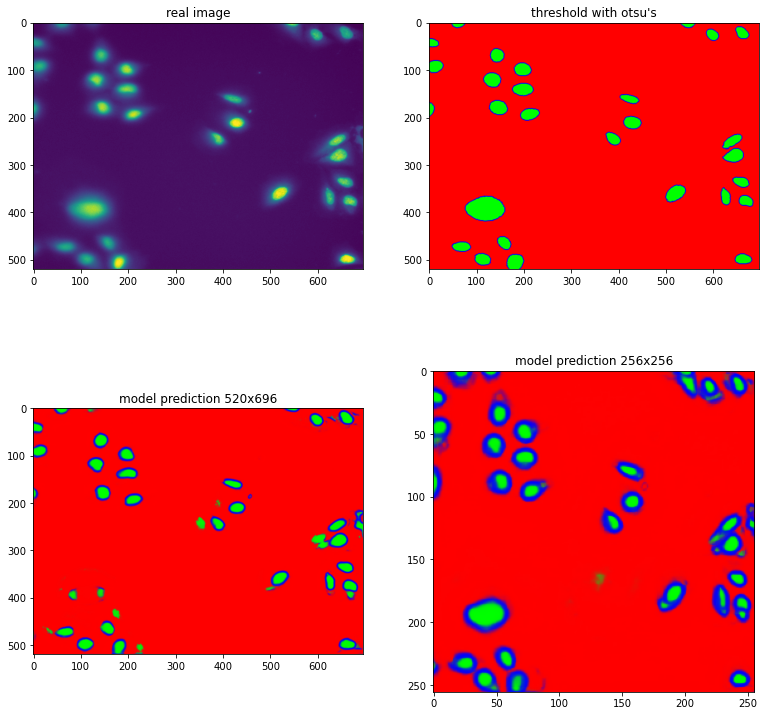

In [3]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[9])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[0])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[0])

plt.figure(figsize=(13,13))
plt.subplot(221)
plt.title("real image")
plt.imshow(img)
plt.subplot(222)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(223)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.savefig("comp.png")
plt.subplot(224)
plt.title("model prediction 256x256")
plt.imshow(i3)
plt.savefig("comp.png")

In [21]:
#thresh = skimage.io.imread(threshold_image_names[9])
#plt.imshow(thresh)

In [5]:
#5

### Make predictions on cropped images (instead of shrinked)

In [2]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'aits_cropped' #cropped to 520x696

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/jupyter',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/jupyter/raw_images/',
 'raw_annotations_dir': '/home/jupyter/raw_annotations/',
 'path_files_training': '/home/jupyter/training.txt',
 'path_files_validation': '/home/jupyter/validation.txt',
 'path_files_test': '/home/jupyter/test.txt',
 'normalized_images_dir': '/home/jupyter/norm_images/',
 'boundary_labels_dir': '/home/jupyter/boundary_labels/',
 'experiment_dir': '/home/jupyter/experime

In [5]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()

dim1 = 520
dim2 = 696


## Crop the desired size
images = images[:, 0:dim1, 0:dim2]
images = images.reshape(-1, dim1, dim2, 1)
#y = y[:, 0:dim1, 0:dim2, :]

## Setup Keras Generators
rescale_factor = 1./(2**8 - 1)

#if(rescale_labels):
#    rescale_factor_labels = rescale_factor
#else:
#    rescale_factor_labels = 1

gen_x = keras.preprocessing.image.ImageDataGenerator(rescale=rescale_factor)
#gen_y = keras.preprocessing.image.ImageDataGenerator(rescale=rescale_factor_labels)


    

In [ ]:
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images, batch_size=1)

#model.summary()

In [ ]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

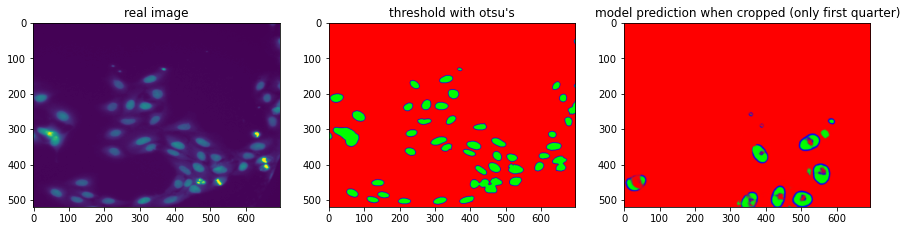

In [10]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits_cropped/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits_cropped/out/prob/' + filename[-1])

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title("real image")
plt.imshow(img)
plt.subplot(132)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(133)
plt.title("model prediction when cropped (only first quarter)")
plt.imshow(i2)
plt.savefig("comp.png")

> Terrible results

### Ellipse fitting

In [137]:
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])

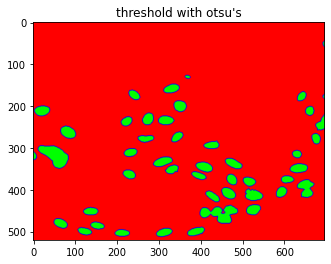

In [138]:
plt.title("threshold with otsu's")
plt.imshow(thresh)

(array([2.47915456, 0.87929513]), 1)


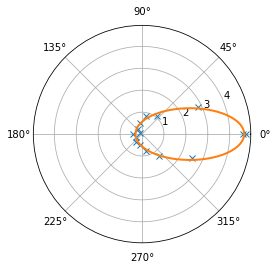

In [14]:
import numpy as np
from scipy import optimize
import pylab

def f(theta, p):
    a, e = p
    return a * (1 - e**2)/(1 - e*np.cos(theta))

# The data to fit
theta = np.array([0.0000,0.4488,0.8976,1.3464,1.7952,2.2440,2.6928,
                  3.1416,3.5904,4.0392,4.4880,4.9368,5.3856,5.8344,6.2832])
r = np.array([4.6073, 2.8383, 1.0795, 0.8545, 0.5177, 0.3130, 0.0945, 0.4303,
              0.3165, 0.4654, 0.5159, 0.7807, 1.2683, 2.5384, 4.7271])

def residuals(p, r, theta):
    """ Return the observed - calculated residuals using f(theta, p). """
    return r - f(theta, p)

def jac(p, r, theta):
    """ Calculate and return the Jacobian of residuals. """
    a, e = p
    da = (1 - e**2)/(1 - e*np.cos(theta))
    de = (-2*a*e*(1-e*np.cos(theta)) + a*(1-e**2)*np.cos(theta))/(1 -
                                                        e*np.cos(theta))**2
    return -da,  -de
    return np.array((-da, -de)).T

# Initial guesses for a, e
p0 = (1, 0.5)
plsq = optimize.leastsq(residuals, p0, Dfun=jac, args=(r, theta), col_deriv=True)
print(plsq)

pylab.polar(theta, r, 'x')
theta_grid = np.linspace(0, 2*np.pi, 200)
pylab.polar(theta_grid, f(theta_grid, plsq[0]), lw=2)
pylab.show()

### Evaluation of otsu's vs model

In [10]:
import utils.evaluation

In [32]:
import pandas as pd

In [22]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [2]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
image_names = ([os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename])
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

In [3]:
imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
images2 = list()
for i in images:
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    images2.append(i)
images2 = np.asarray(images2)

In [8]:
im = images2[7]
thresh_val = skimage.filters.threshold_otsu(im) #find threshold using otsus method
mask = im > thresh_val # create mask 
#object_labels = skimage.measure.label(mask) # convert to skimage label
annot = skimage.morphology.label(mask) # convert to annotation

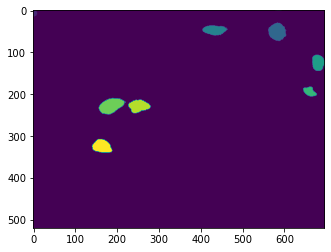

In [7]:
plt.imshow(annot)

In [9]:
i = '/home/jupyter/MFGTMPcx7_170803210001_B19f26d0.png'

In [10]:
i = skimage.io.imread(i)

In [11]:
i = skimage.morphology.label(i)

In [12]:
i = resize(i, (520, 696), mode='constant', preserve_range=True)

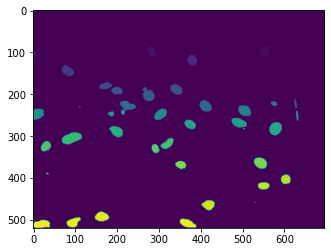

In [14]:
plt.imshow(i[:,:,0])

In [16]:
i2 = '/home/jupyter/aitslab_images/raw_annotations/MFGTMPcx7_170803210001_B19f26d0.png'

In [17]:
i2 = skimage.io.imread(i2)


In [18]:
i2 = skimage.morphology.label(i2)

In [19]:
i2 = resize(i2, (520, 696), mode='constant', preserve_range=True)

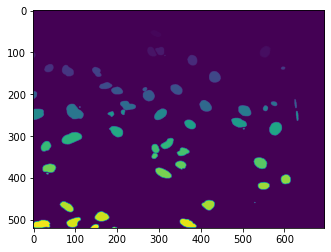

In [21]:
#plt.imshow(i[:,:,0])
plt.imshow(i2[:,:,0])

In [26]:
from config import config_vars

In [31]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])


# Transform to label matrix
ground_truth = i2[:,:,0]

# Load predictions
pred_filename = os.path.join('/home/jupyter/experiments/MA_1/out/segm/', 'MFGTMPcx7_170803210001_B19f26d0.png')
#prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
prediction = skimage.io.imread(pred_filename)

# Apply object dilation
if config_vars["object_dilation"] > 0:
    struct = skimage.morphology.square(config_vars["object_dilation"])
    prediction = skimage.morphology.dilation(prediction, struct)
elif config_vars["object_dilation"] < 0:
    struct = skimage.morphology.square(-config_vars["object_dilation"])
    prediction = skimage.morphology.erosion(prediction, struct)

# Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]

# Compute evaluation metrics
results = utils.evaluation.compute_af1_results(
    ground_truth, 
    prediction, 
    results, 
    'MFGTMPcx7_170803210001_B19f26d0.png'
)

    
false_negatives = utils.evaluation.get_false_negatives(
    ground_truth, 
    prediction, 
    false_negatives, 
    'MFGTMPcx7_170803210001_B19f26d0.png'
)

splits_merges = utils.evaluation.get_splits_and_merges(
    ground_truth, 
    prediction, 
    splits_merges, 
    'MFGTMPcx7_170803210001_B19f26d0.png'
)
    


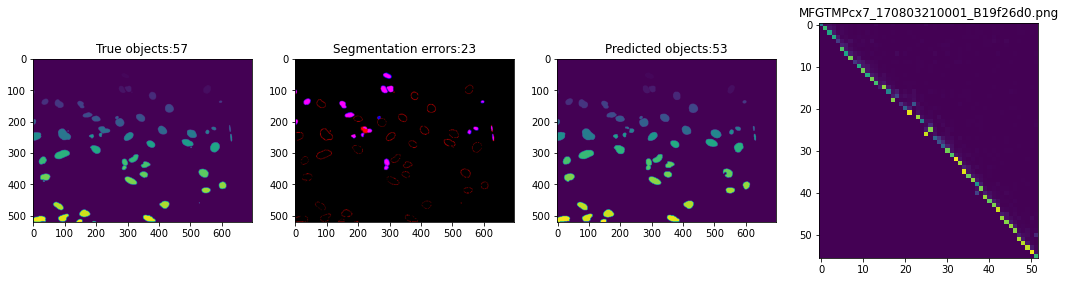

In [32]:
show(ground_truth, prediction, image_name='MFGTMPcx7_170803210001_B19f26d0.png')
#plt.savefig("comp.png")

In [36]:
i = '/home/jupyter/aitslab_images/raw_annotations/MFGTMPcx7_170803210001_A01f29d0_aug_001.png'

In [37]:
i = skimage.io.imread(i)

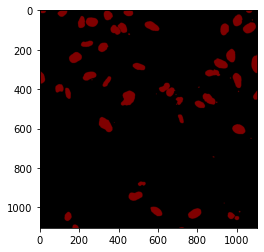

In [38]:
plt.imshow(i)

In [41]:
i = (skimage.morphology.label(i))

In [ ]:
i = resize()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


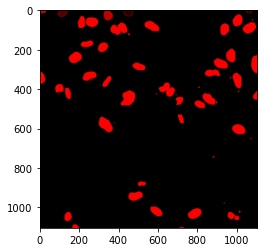

In [39]:
ground_truth = skimage.io.imread(img_filename)
ground_truth = skimage.morphology.label(ground_truth)
ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)

if len(ground_truth.shape) == 3:
    ground_truth = ground_truth[:,:,0]

In [62]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])


# Transform to label matrix
ground_truth = skimage.morphology.label(annot)

# Load predictions
pred_filename = os.path.join('/home/jupyter/experiments/aits2/out/segm/', filename[-1])
#prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
prediction = skimage.io.imread(pred_filename)

# Apply object dilation
if config_vars["object_dilation"] > 0:
    struct = skimage.morphology.square(config_vars["object_dilation"])
    prediction = skimage.morphology.dilation(prediction, struct)
elif config_vars["object_dilation"] < 0:
    struct = skimage.morphology.square(-config_vars["object_dilation"])
    prediction = skimage.morphology.erosion(prediction, struct)

# Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]

# Compute evaluation metrics
results = utils.evaluation.compute_af1_results(
    ground_truth, 
    prediction, 
    results, 
    filename[-1]
)

### Adding manually annotated images 

#### find out which images to manually annotate

In [139]:
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])

In [152]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

In [161]:
normal_images = skimage.io.imread_collection(image_names)
normal_images = normal_images.concatenate()

In [159]:
pred_images = sorted(os.listdir('/home/jupyter/experiments/aits2/out/prob'))
pred_names = [os.path.join('/home/jupyter/experiments/aits2/out/prob', f) for f in filename]
pred_names.remove('/home/jupyter/experiments/aits2/out/prob/.ipynb_checkpoints')


In [162]:
pred_images = skimage.io.imread_collection(pred_names)
pred_images = pred_images.concatenate()

In [145]:
imagebuffer = skimage.io.imread_collection(threshold_image_names)

images = imagebuffer.concatenate()

Image nbr: 0


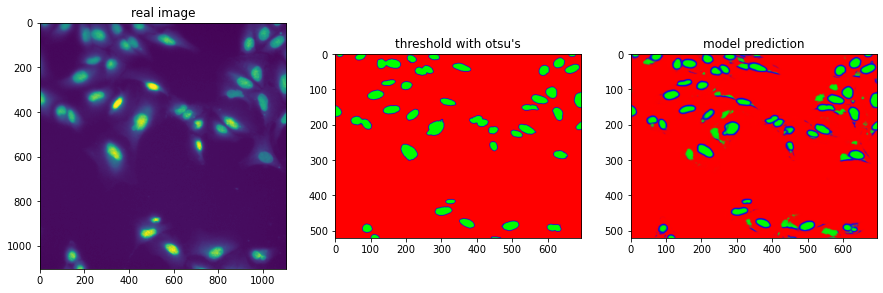

Image nbr: 1


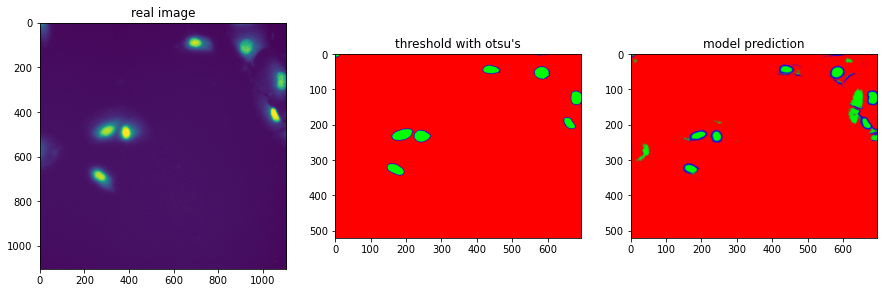

Image nbr: 2


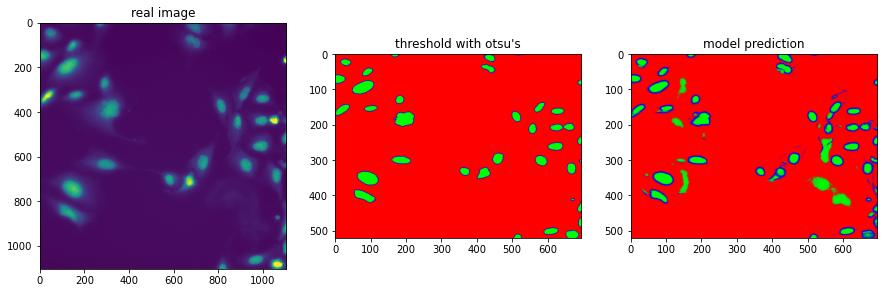

Image nbr: 3


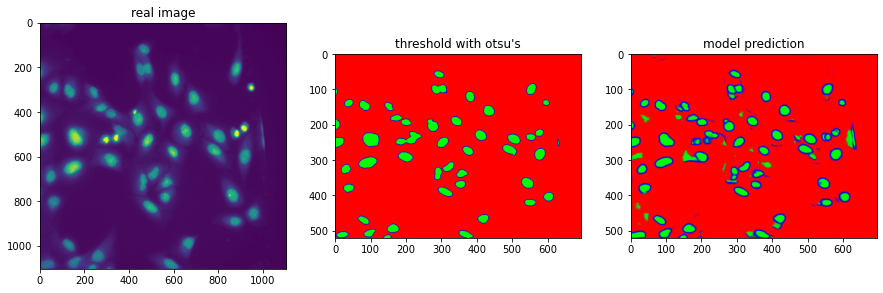

Image nbr: 4


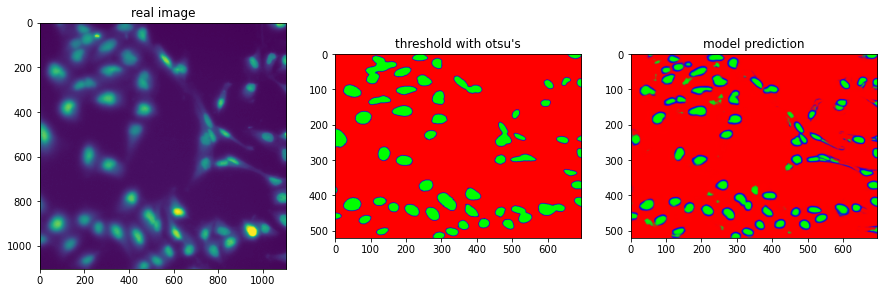

Image nbr: 5


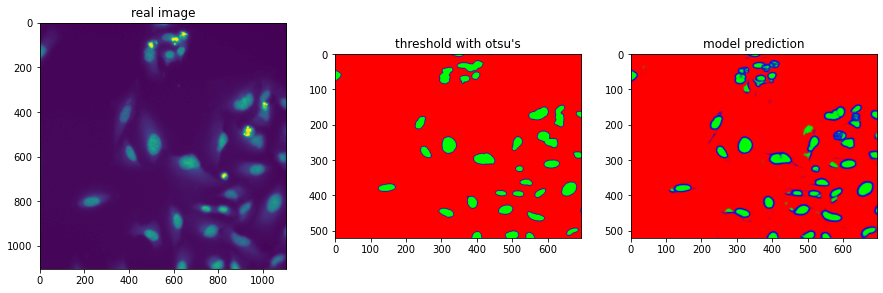

Image nbr: 6


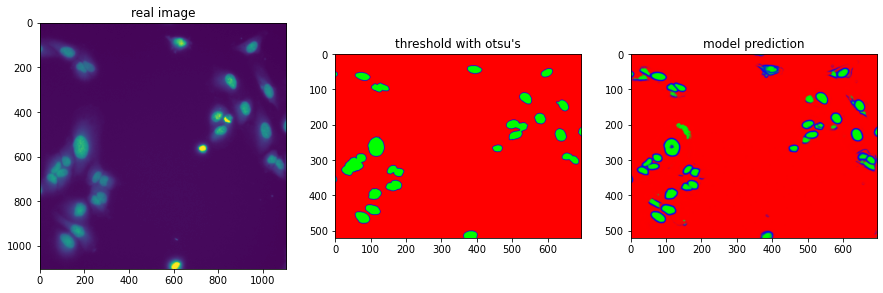

Image nbr: 7


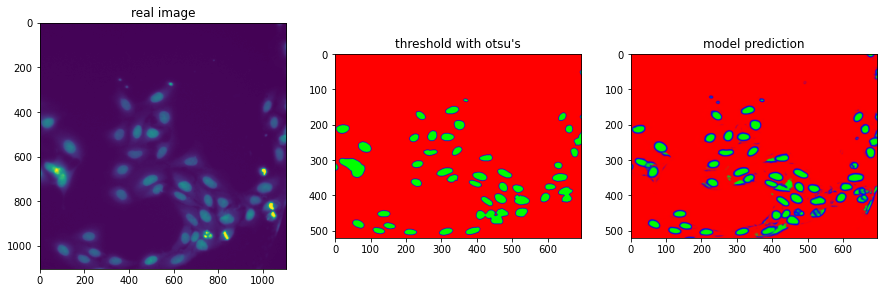

Image nbr: 8


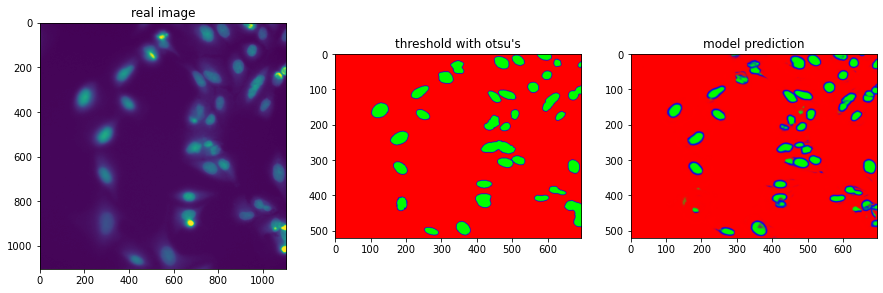

Image nbr: 9


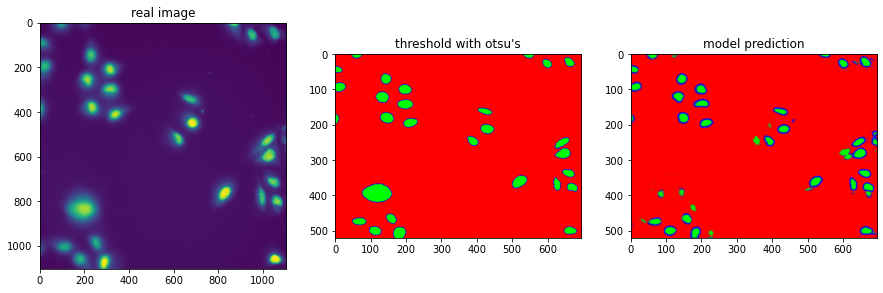

Image nbr: 10


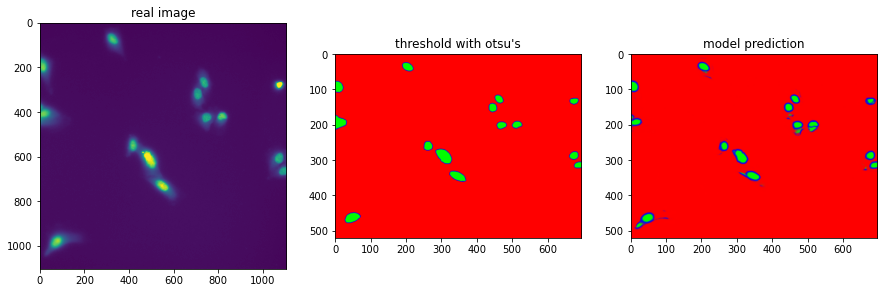

Image nbr: 11


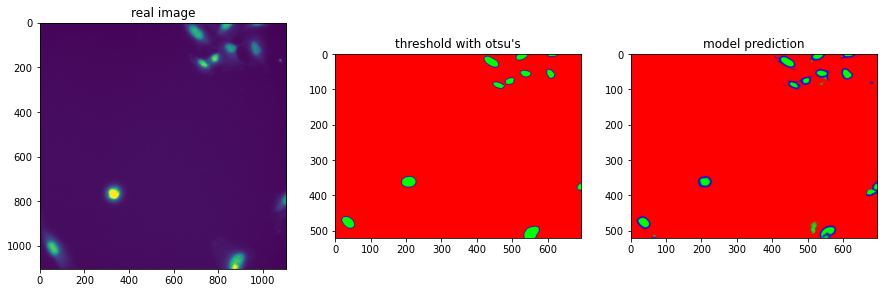

Image nbr: 12


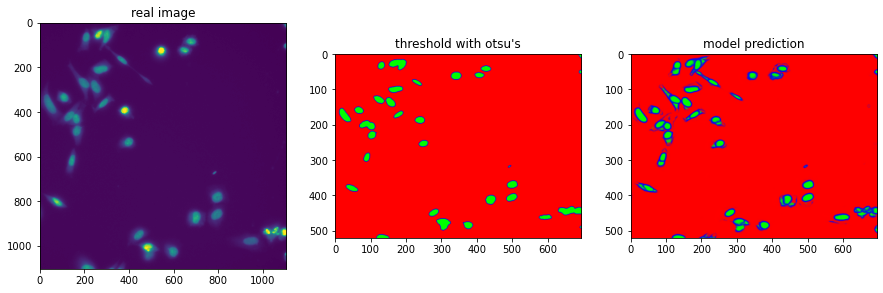

Image nbr: 13


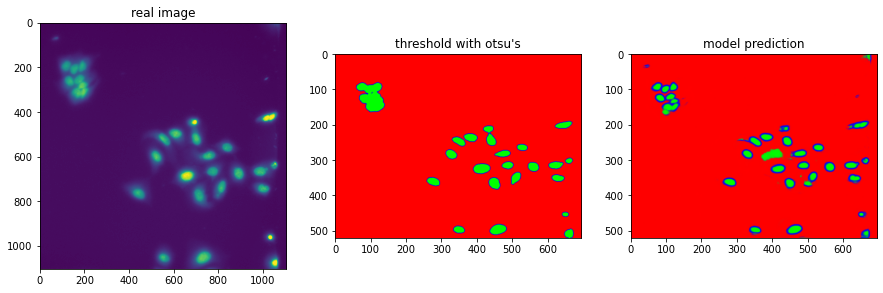

In [170]:
for n,i in enumerate(images):
    print("Image nbr: " + str(n))
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("real image")
    plt.imshow(normal_images[n])
    plt.subplot(132)
    plt.title("threshold with otsu's")
    plt.imshow(i)
    plt.subplot(133)
    plt.title("model prediction")
    plt.imshow(pred_images[n])
    plt.show()
    #plt.savefig("comp.png")

> 0, 1 2 4 7 9 13

### create new folder for reshaped norm_images

In [171]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

In [175]:
filename.remove('.ipynb_checkpoints')

In [176]:
imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
#images2 = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    skimage.io.imsave('/home/jupyter/aitslab_images/reshaped_images/' + filename[n], i)
    #images2.append(i)
#images2 = np.asarray(images2)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


### test one of the manually annotated images

In [195]:
test = skimage.io.imread('/home/jupyter/aitslab_images/raw_annotations/' + 'MFGTMPcx7_170803210001_A01f29d0.png')

In [197]:
test2 = skimage.morphology.label(test[:,:,0])

In [201]:
label_binary = np.zeros((test2.shape + (3,)))

boundaries = skimage.segmentation.find_boundaries(test2) #extract boundaries

for k in range(2, config_vars["boundary_size"], 2):
    boundaries = skimage.morphology.binary_dilation(boundaries)
    

# write binary label
label_binary[(test2 == 0) & (boundaries == 0), 0] = 1
label_binary[(test2 != 0) & (boundaries == 0), 1] = 1
label_binary[boundaries == 1, 2] = 1

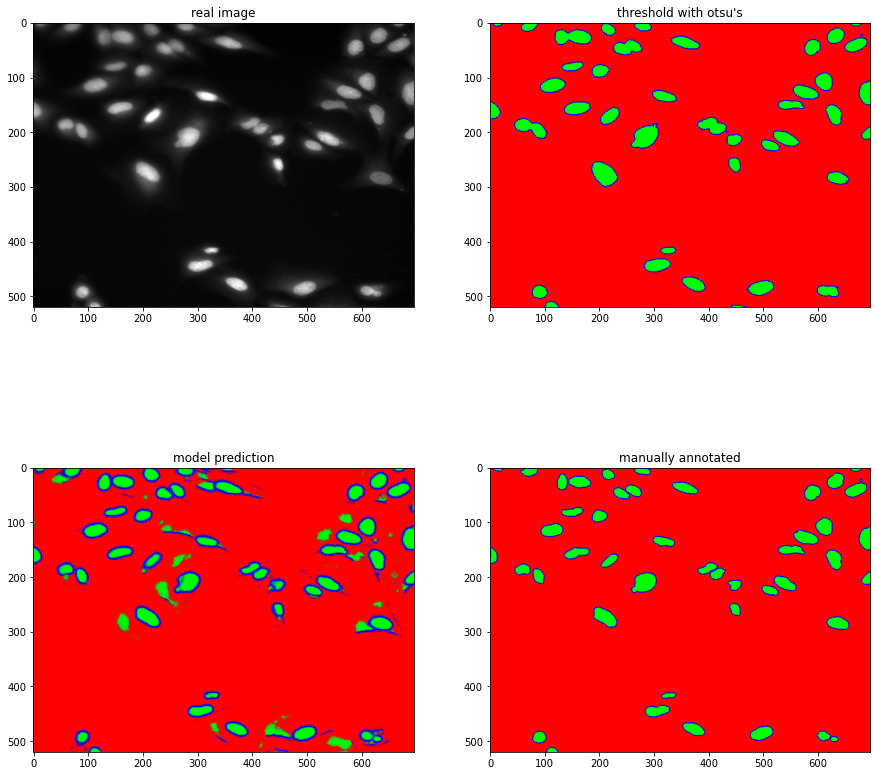

In [224]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename.remove('.ipynb_checkpoints')
img = skimage.io.imread('/home/jupyter/aitslab_images/reshaped_images/' + filename[0])
#img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = sorted(os.listdir('/home/jupyter/aitslab_images/boundary_labels'))
threshold_images.remove('.ipynb_checkpoints')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
#threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[0])
f2 = sorted(os.listdir('/home/jupyter/experiments/aits2/out/prob'))
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[0])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title("real image")
plt.imshow(img, cmap="gray")
plt.subplot(222)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(223)
plt.title("model prediction")
plt.imshow(i2)
plt.subplot(224)
plt.title("manually annotated")
plt.imshow(label_binary)
plt.savefig("comp2.png")

#### Manually annotated model predict on images:

In [2]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'MA_1' #convert to 520x696 (same as BBBC)

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/jupyter',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/jupyter/raw_images/',
 'raw_annotations_dir': '/home/jupyter/raw_annotations/',
 'path_files_training': '/home/jupyter/training.txt',
 'path_files_validation': '/home/jupyter/validation.txt',
 'path_files_test': '/home/jupyter/test.txt',
 'normalized_images_dir': '/home/jupyter/norm_images/',
 'boundary_labels_dir': '/home/jupyter/boundary_labels/',
 'experiment_dir': '/home/jupyter/experime

In [3]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

In [4]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename.remove('.ipynb_checkpoints')
image_names = [os.path.join('/home/jupyter/aitslab_images/reshaped_images', f) for f in filename]
#image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
#images2 = list()
#for i in images:
#    i = resize(i, (520, 696), mode='constant', preserve_range=True)
#    images2.append(i)


dim1 = images.shape[1]
dim2 = images.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images = images.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])
#model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images, batch_size=1)

#model.summary()

/home/jupyter/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/jupyter/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jupyter/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/jupyter/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jupyter/utils/model_builder.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padd

MFGTMPcx7_170803210001_A01f29d0.png


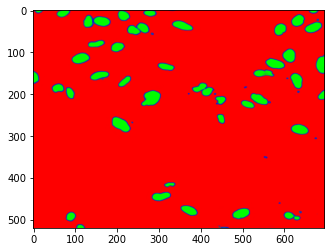

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


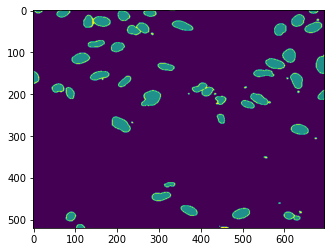

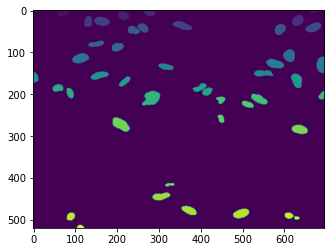

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A01f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A01f29d0_aug_001.png


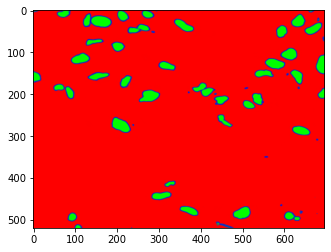

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


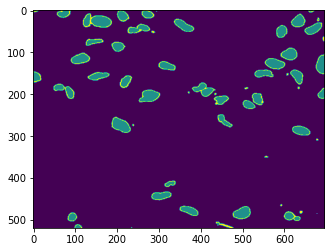

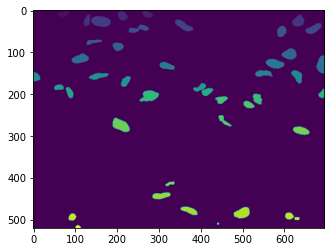

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A01f29d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 45]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A01f29d0_aug_002.png


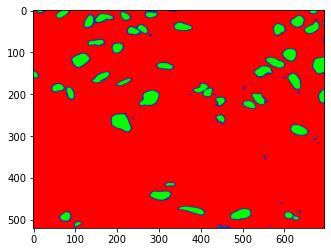

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


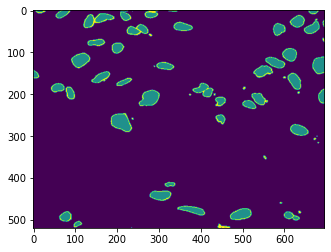

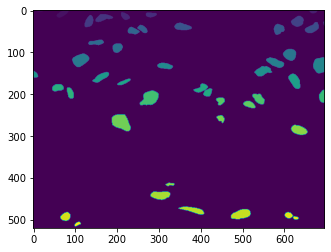

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A01f29d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 46]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A01f29d0_aug_003.png


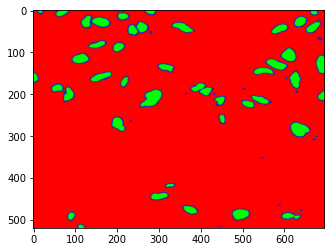

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


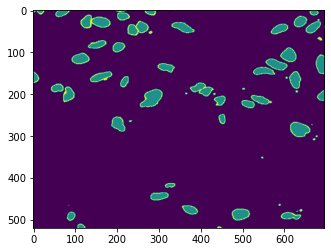

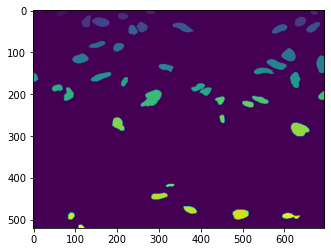

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A01f29d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A01f29d0_aug_004.png


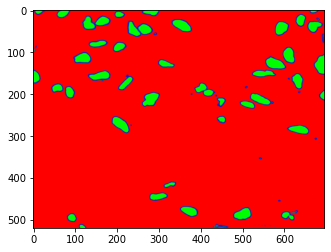

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


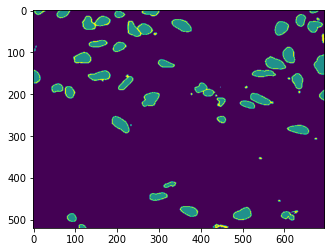

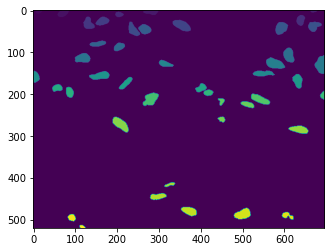

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A01f29d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0.png


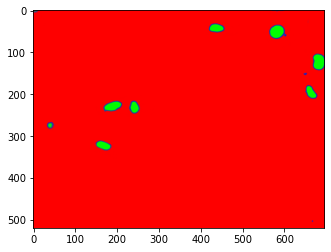

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


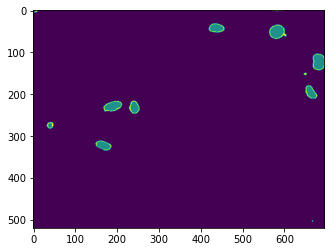

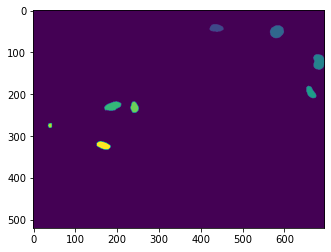

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A05f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 9]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0_aug_001.png


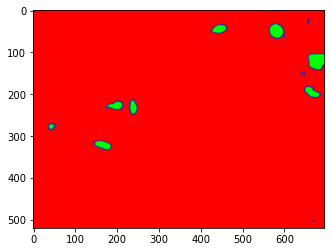

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


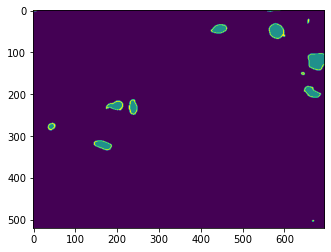

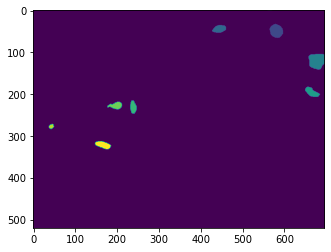

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A05f27d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 9]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0_aug_002.png


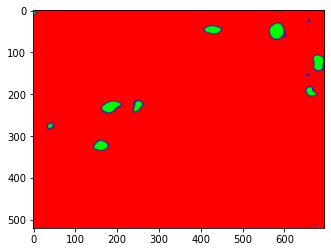

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


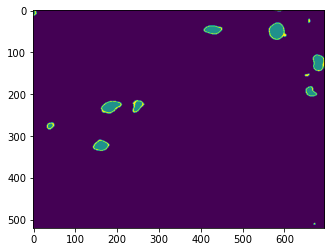

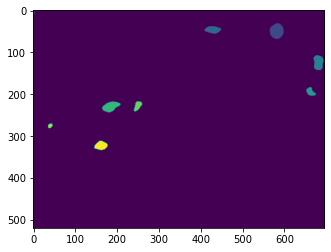

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A05f27d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 9]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0_aug_003.png


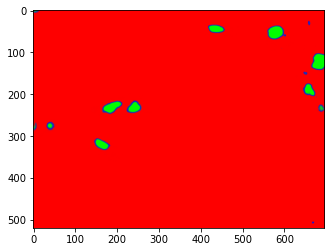

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


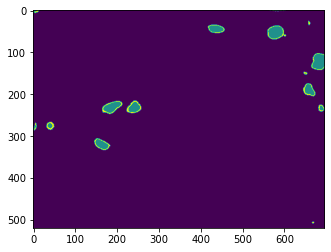

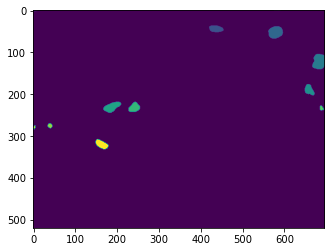

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A05f27d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 12]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0_aug_004.png


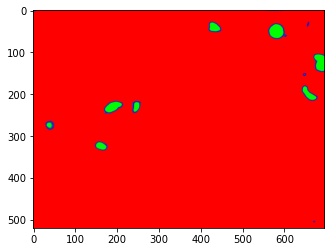

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


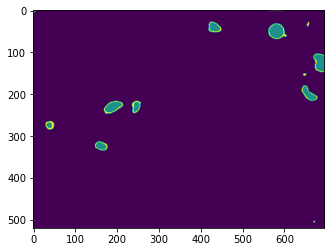

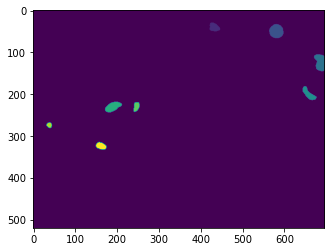

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_A05f27d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 8]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0.png


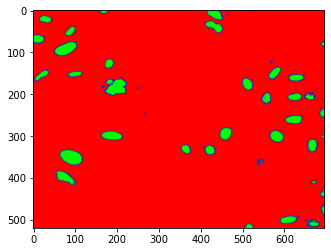

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


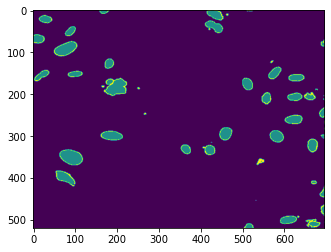

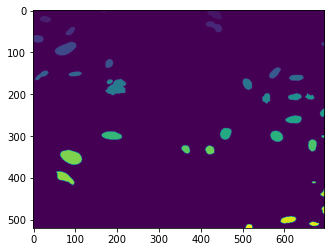

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 36]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0.png


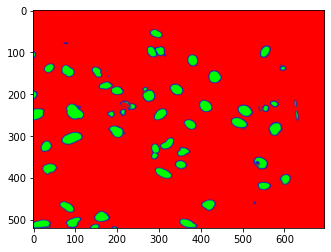

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


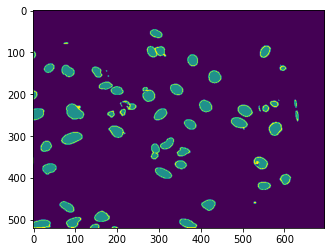

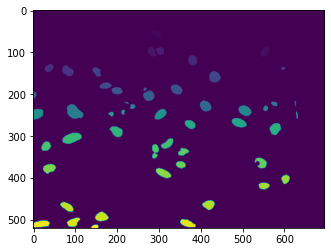

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_D04f27d0.png


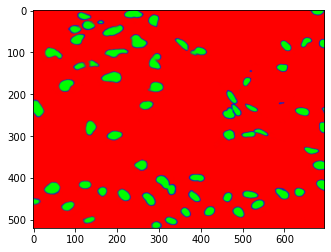

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


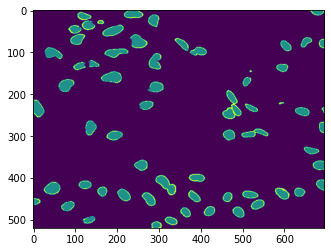

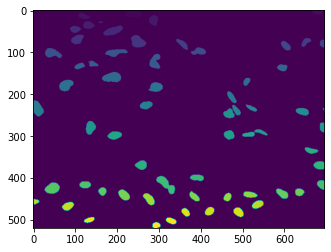

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_D04f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_I06f29d0.png


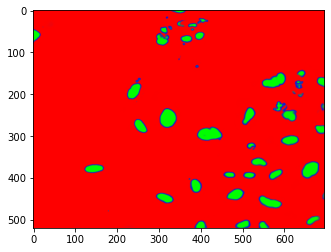

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


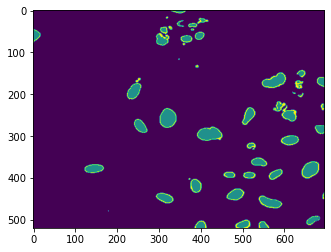

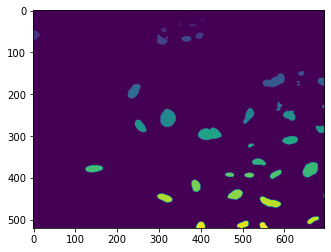

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_I06f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 40]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_I07f27d0.png


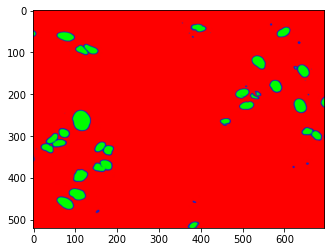

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


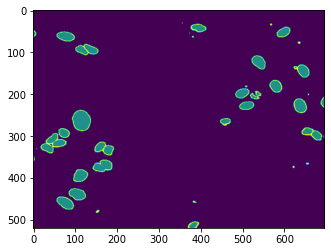

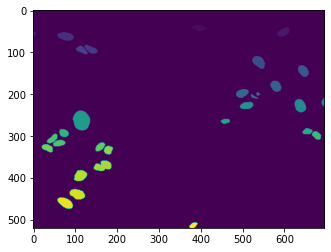

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_I07f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 29]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0.png


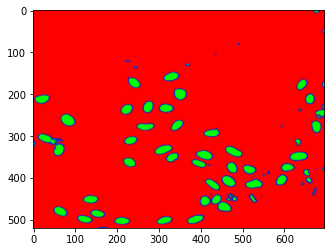

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


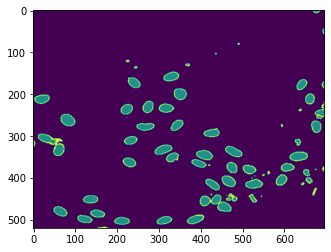

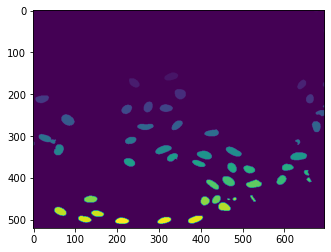

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_J12f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 53]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0_aug_001.png


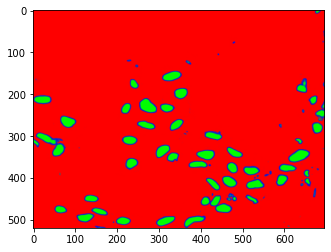

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


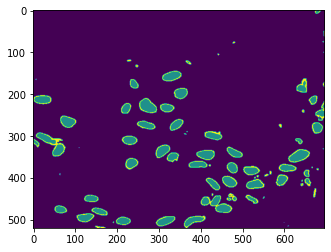

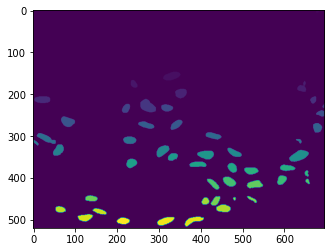

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_J12f29d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0_aug_002.png


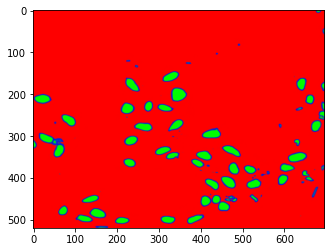

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


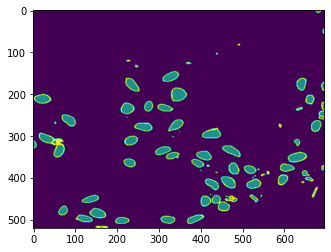

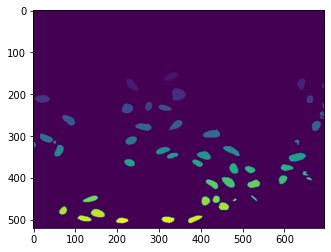

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_J12f29d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 53]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0_aug_003.png


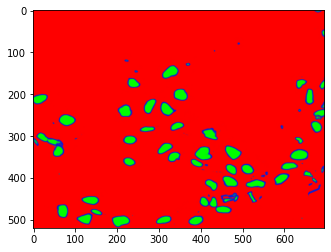

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


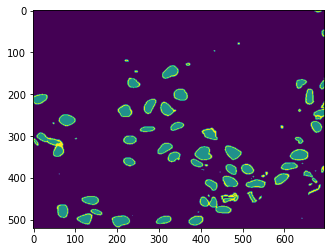

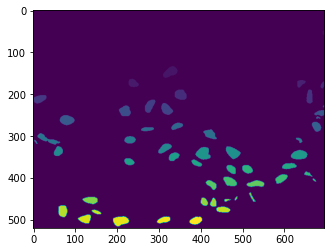

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_J12f29d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 54]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0_aug_004.png


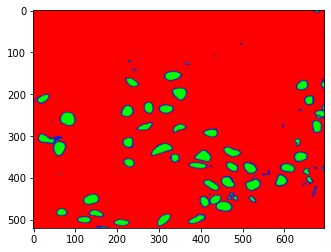

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


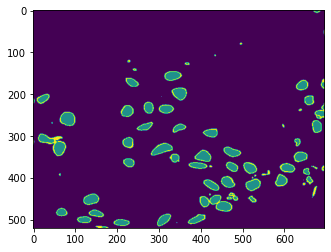

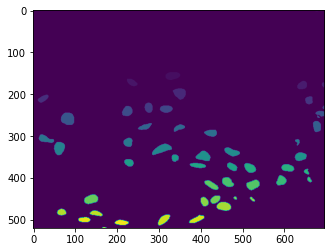

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_J12f29d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_L13f27d0.png


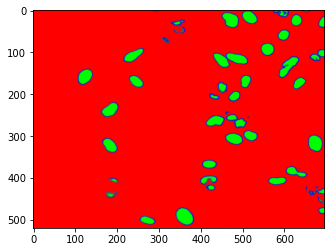

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


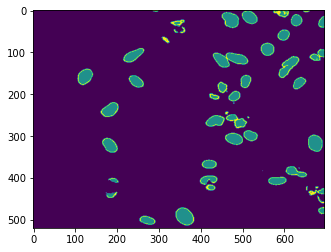

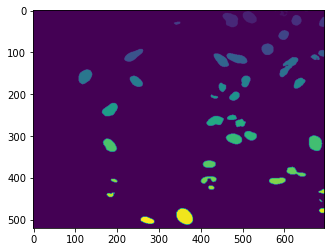

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_L13f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_L14f27d0.png


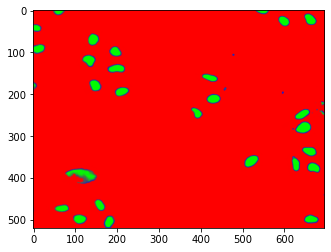

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


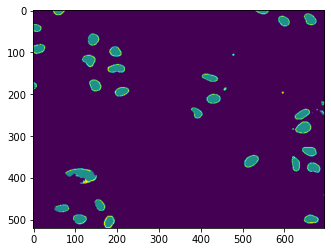

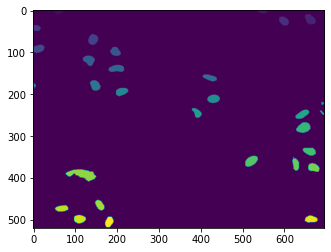

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_L14f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 30]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_O09f27d0.png


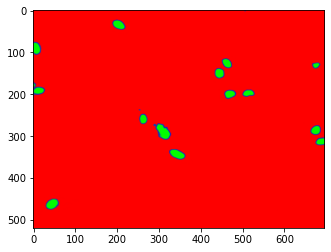

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


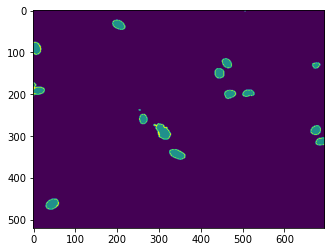

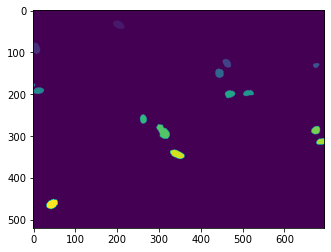

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_O09f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P09f27d0.png


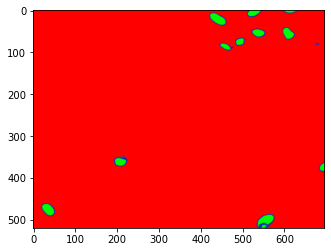

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


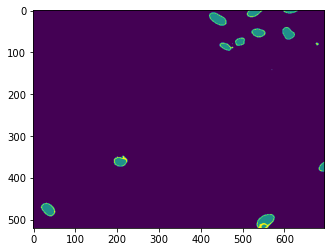

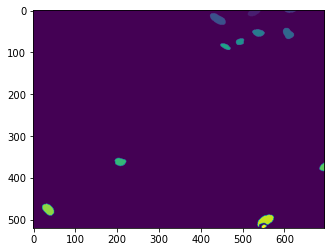

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_P09f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 12]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P17f28d0.png


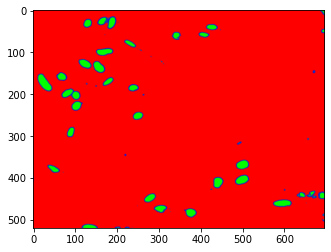

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


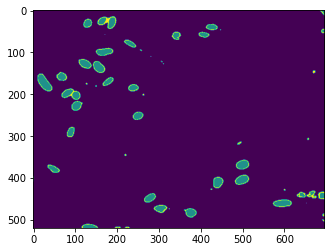

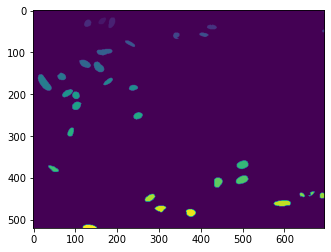

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_P17f28d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 33]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P22f27d0.png


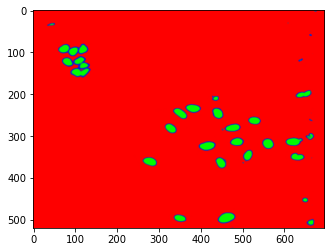

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


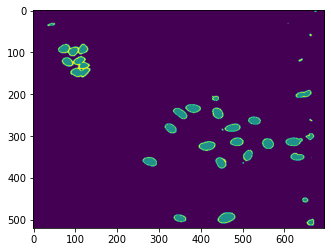

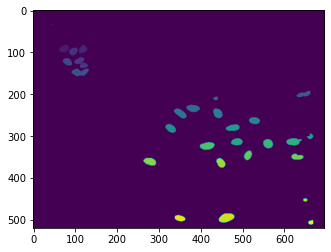

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_P22f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 28]. Convert image to uint8 prior to saving to suppress this warning.


In [5]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

### predict on manually annotated images and evaluate

#### predict

In [38]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
#partition = "validation"

experiment_name = 'MA_1' #

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/jupyter',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/jupyter/raw_images/',
 'raw_annotations_dir': '/home/jupyter/raw_annotations/',
 'path_files_training': '/home/jupyter/training.txt',
 'path_files_validation': '/home/jupyter/validation.txt',
 'path_files_test': '/home/jupyter/test.txt',
 'normalized_images_dir': '/home/jupyter/norm_images/',
 'boundary_labels_dir': '/home/jupyter/boundary_labels/',
 'experiment_dir': '/home/jupyter/experime

In [13]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

In [14]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename = [f for f in filename if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']
image_names = [os.path.join('/home/jupyter/aitslab_images/reshaped_images', f) for f in filename]


#image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

#images2 = list()
#for i in images:
#    i = resize(i, (520, 696), mode='constant', preserve_range=True)
#    images2.append(i)


dim1 = images.shape[1]
dim2 = images.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images = images.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])
#model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images, batch_size=1)

#model.summary()

MFGTMPcx7_170803210001_B18f27d0.png


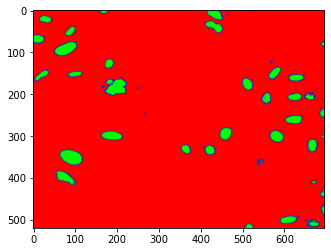

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


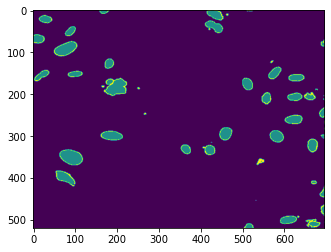

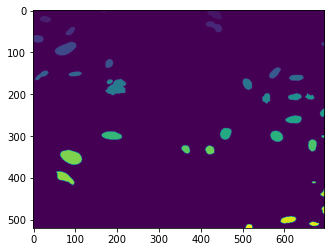

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 36]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_001.png


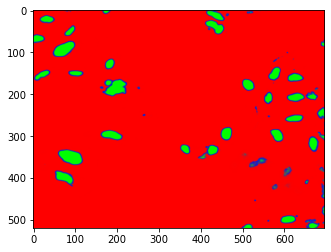

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


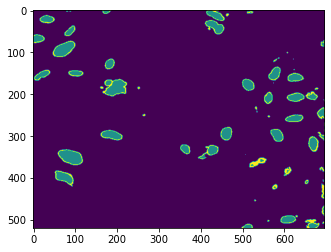

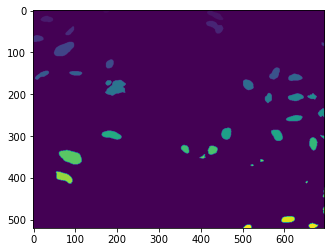

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 39]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_002.png


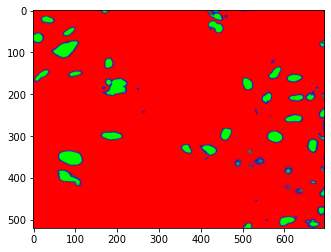

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


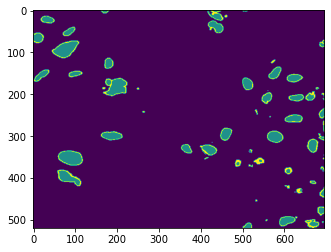

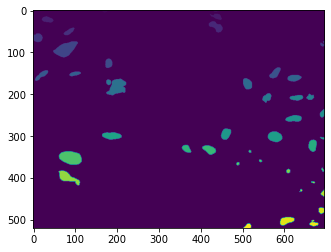

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_003.png


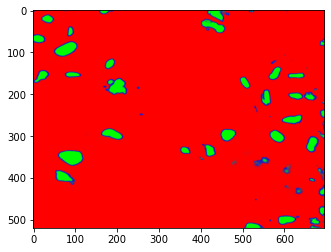

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


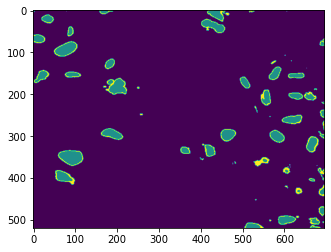

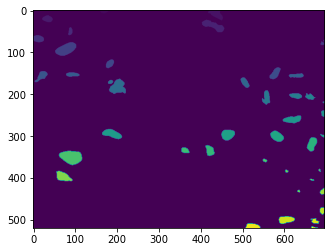

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 42]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_004.png


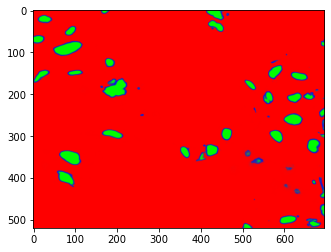

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


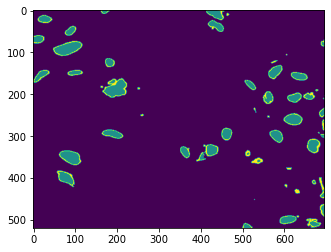

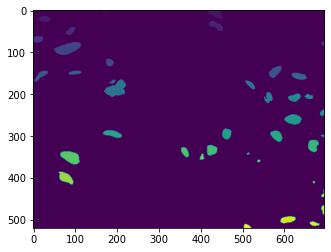

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 39]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0.png


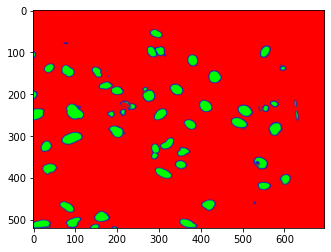

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


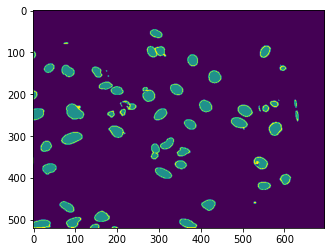

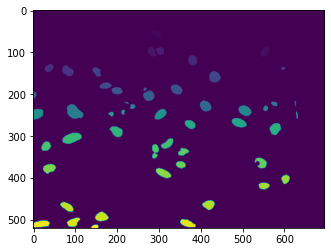

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_001.png


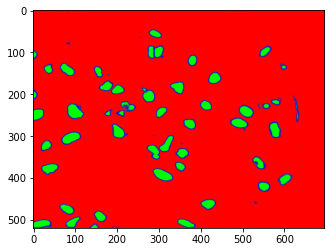

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


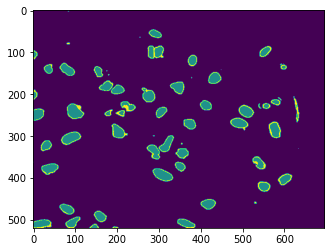

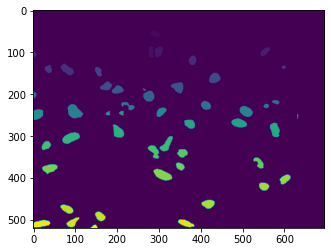

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_002.png


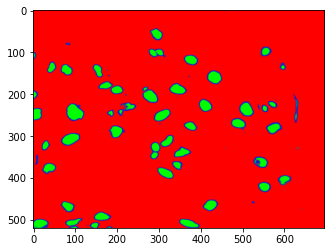

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


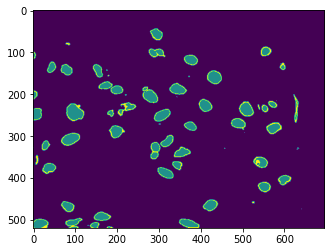

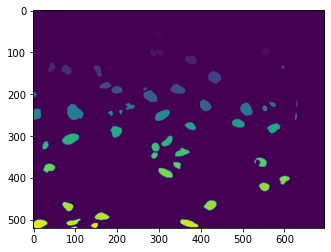

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_003.png


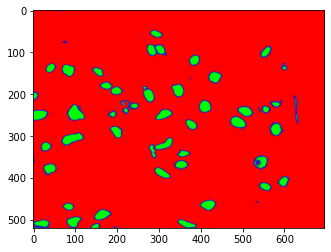

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


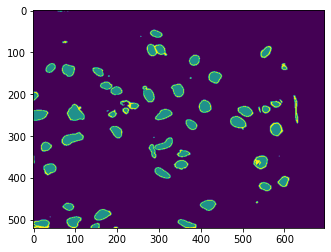

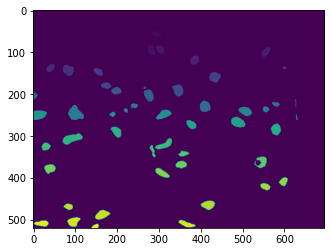

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 50]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_004.png


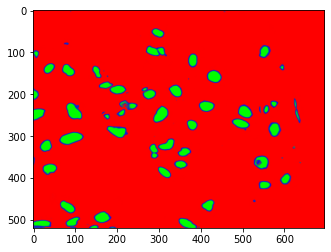

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


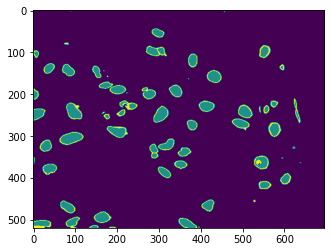

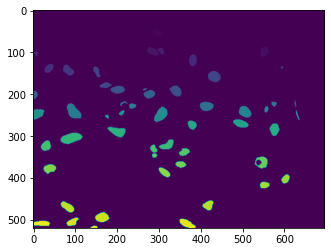

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_1/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 53]. Convert image to uint8 prior to saving to suppress this warning.


In [15]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

#### evaluate

In [18]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [36]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename = [f for f in filename if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']
image_names = [os.path.join('/home/jupyter/aitslab_images/reshaped_images', f) for f in filename]

In [21]:
import pandas as pd

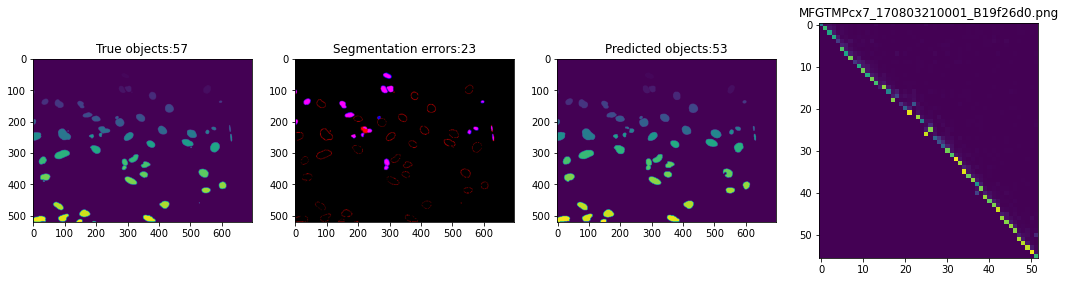

In [64]:
all_images = filename

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[5]:
        show(ground_truth, prediction, image_name=image_name)

In [41]:
import seaborn as sb

In [43]:
R

Image  Threshold        F1   Jaccard
0          MFGTMPcx7_170803210001_B18f27d0.png      0.725  0.139535  0.519709
1  MFGTMPcx7_170803210001_B18f27d0_aug_001.png      0.725  0.009784  0.614431
2  MFGTMPcx7_170803210001_B18f27d0_aug_002.png      0.725  0.010194  0.567317
3  MFGTMPcx7_170803210001_B18f27d0_aug_003.png      0.725  0.010288  0.577763
4  MFGTMPcx7_170803210001_B18f27d0_aug_004.png      0.725  0.010598  0.627871
5          MFGTMPcx7_170803210001_B19f26d0.png      0.725  0.179630  0.499095
6  MFGTMPcx7_170803210001_B19f26d0_aug_001.png      0.725  0.011653  0.722520
7  MFGTMPcx7_170803210001_B19f26d0_aug_002.png      0.725  0.011576  0.702836
8  MFGTMPcx7_170803210001_B19f26d0_aug_003.png      0.725  0.011847  0.711897
9  MFGTMPcx7_170803210001_B19f26d0_aug_004.png      0.725  0.011773  0.704434

Threshold        F1   Jaccard
0       0.50  0.126932  0.624787
1       0.55  0.105393  0.624787
2       0.60  0.084315  0.624787
3       0.65  0.047288  0.624787
4       0.70  0.026147  0.624787
5       0.75  0.012730  0.624787
6       0.80  0.003267  0.624787
7       0.85  0.000806  0.624787
8       0.90  0.000000  0.624787
9       0.95  0.000000  0.624787

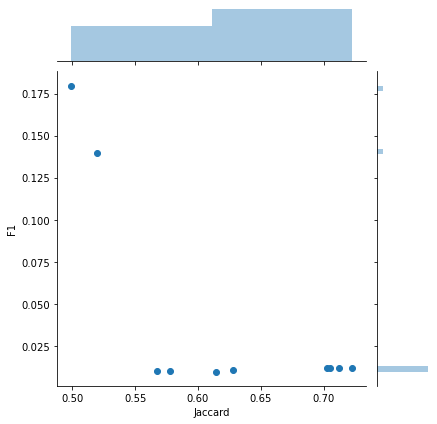

In [48]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R, x="Jaccard", y="F1")

average_performance
#R.sort_values(by="F1",ascending=False).loc[, "Image"]

Threshold        F1   Jaccard
0       0.50  0.126932  0.624787
1       0.55  0.105393  0.624787
2       0.60  0.084315  0.624787
3       0.65  0.047288  0.624787
4       0.70  0.026147  0.624787
5       0.75  0.012730  0.624787
6       0.80  0.003267  0.624787
7       0.85  0.000806  0.624787
8       0.90  0.000000  0.624787
9       0.95  0.000000  0.624787

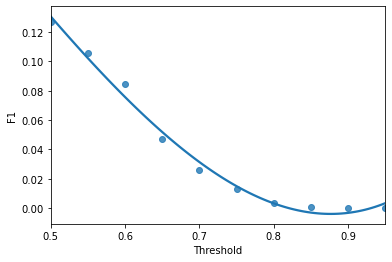

In [49]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [50]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      28461
Small nuclei        94
Normal nuclei        5
Large nuclei         2
Name: False_Negative, dtype: int64

In [51]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 229


> we are missing a few nuclei it seems 

### predict and evaluate again with less elastic distortion

In [9]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
#partition = "validation"

experiment_name = 'MA_2' #

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

In [10]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

In [14]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename = [f for f in filename if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']
image_names = [os.path.join('/home/jupyter/aitslab_images/reshaped_images/', f) for f in filename]


#image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

#images2 = list()
#for i in images:
#    i = resize(i, (520, 696), mode='constant', preserve_range=True)
#    images2.append(i)


dim1 = images.shape[1]
dim2 = images.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images = images.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
#model.load_weights('/home/jupyter/experiments/01/model.hdf5')
model.load_weights('/home/jupyter/experiments/MA_1/model.hdf5')

# Normal prediction time
predictions = model.predict(images, batch_size=1)

#model.summary()

MFGTMPcx7_170803210001_B18f27d0.png


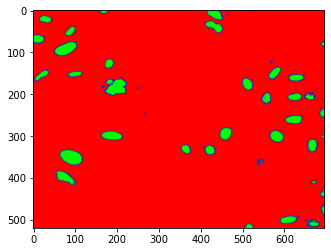

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


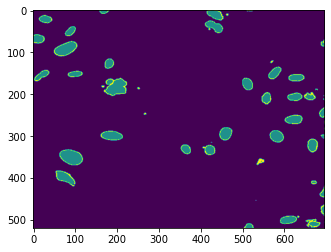

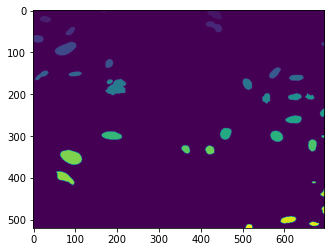

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B18f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 36]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_001.png


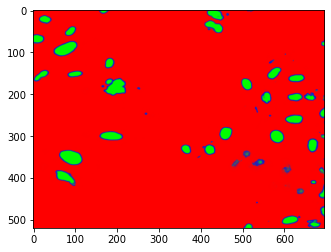

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


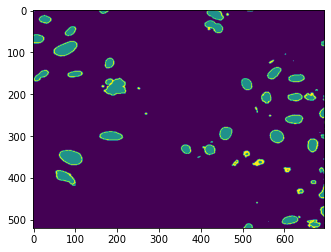

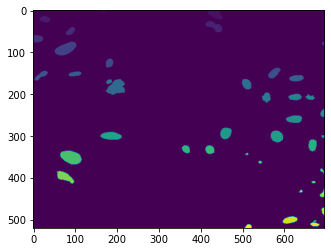

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_002.png


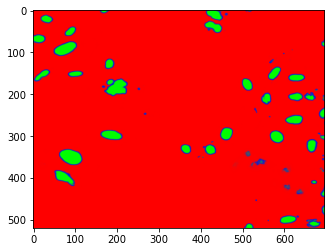

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


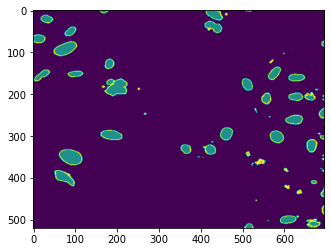

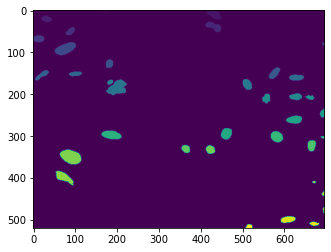

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 36]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_003.png


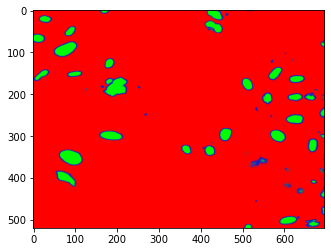

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


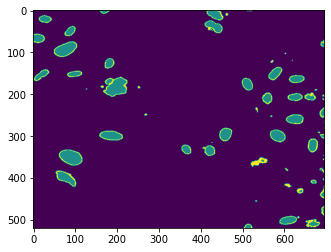

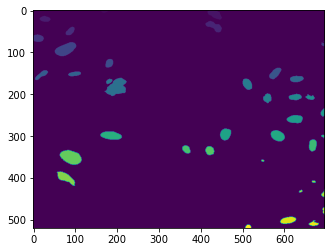

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 38]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0_aug_004.png


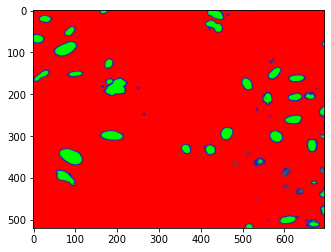

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


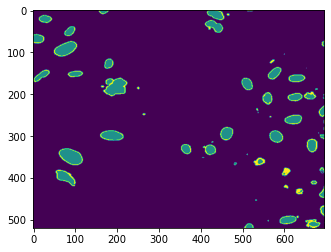

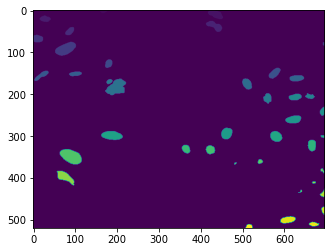

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B18f27d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 40]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0.png


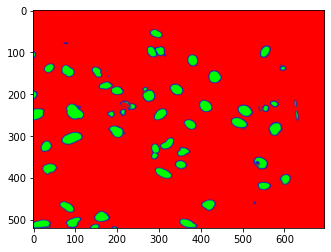

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


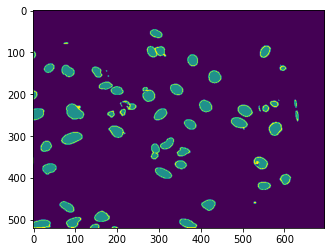

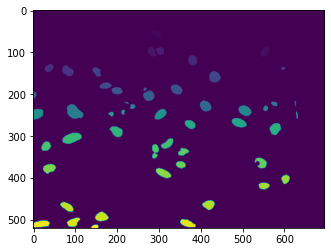

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B19f26d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_001.png


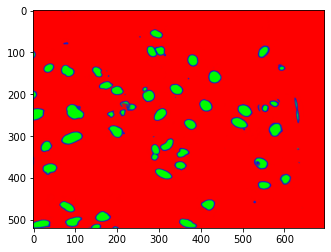

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


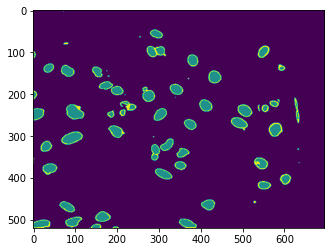

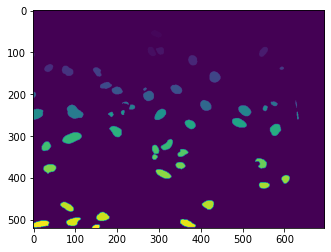

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_001.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 53]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_002.png


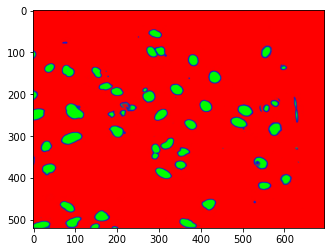

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


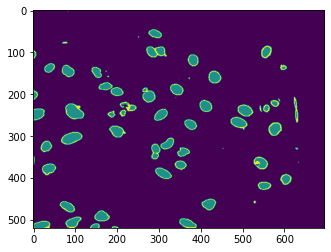

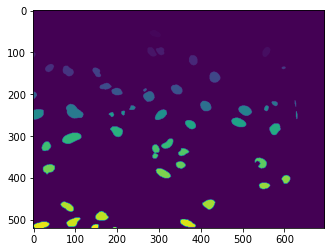

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_002.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_003.png


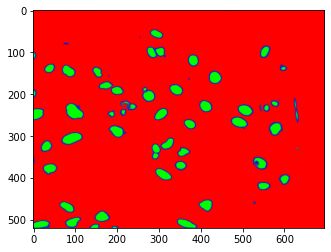

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


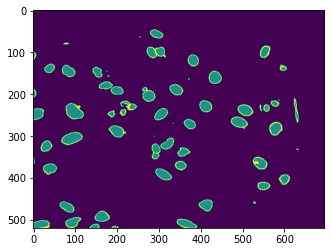

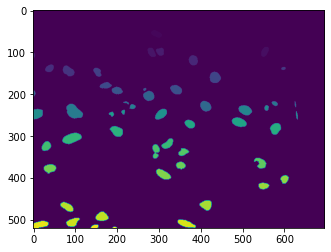

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_003.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 53]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0_aug_004.png


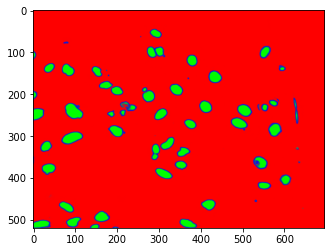

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


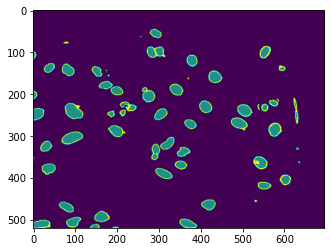

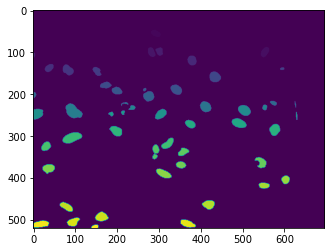

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_2/out/segm/MFGTMPcx7_170803210001_B19f26d0_aug_004.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 52]. Convert image to uint8 prior to saving to suppress this warning.


In [15]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

#### evaluate

In [24]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    #ax[3].imshow(IOU)
    #ax[3].set_title(image_name)

In [21]:
filename = sorted(os.listdir('/home/jupyter/aitslab_images/reshaped_images'))
filename = [f for f in filename if f == 'MFGTMPcx7_170803210001_B18f27d0.png' or f == 'MFGTMPcx7_170803210001_B19f26d0.png']
image_names = [os.path.join('/home/jupyter/aitslab_images/reshaped_images', f) for f in filename]

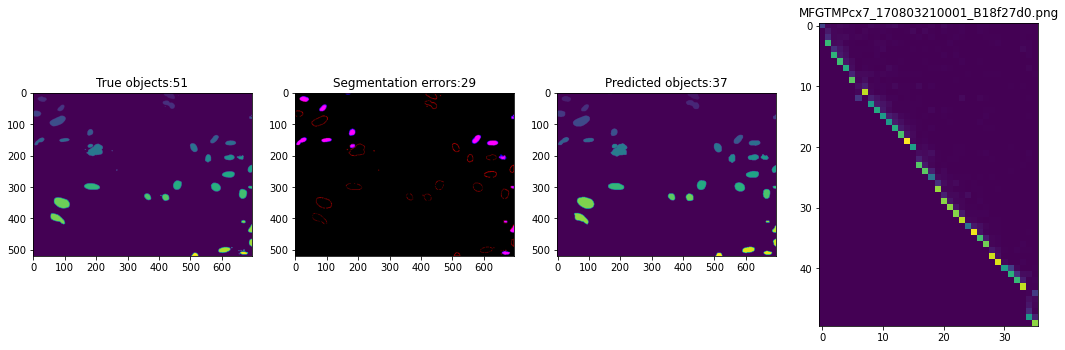

In [23]:
all_images = filename

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

Threshold        F1   Jaccard
0       0.50  0.549742  0.509402
1       0.55  0.445306  0.509402
2       0.60  0.343239  0.509402
3       0.65  0.164729  0.509402
4       0.70  0.071921  0.509402
5       0.75  0.020887  0.509402
6       0.80  0.000000  0.509402
7       0.85  0.000000  0.509402
8       0.90  0.000000  0.509402
9       0.95  0.000000  0.509402

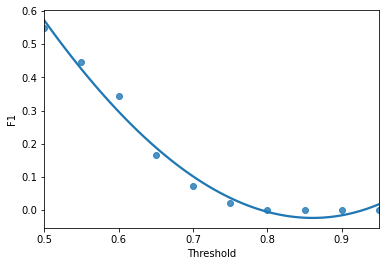

In [27]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [28]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      40
Small nuclei     53
Normal nuclei     4
Large nuclei      2
Name: False_Negative, dtype: int64

### predict and evaluate with no elastic distortion

#### predict

In [42]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
#partition = "validation"

experiment_name = 'MA_3' #

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

#data_partitions = utils.dirtools.read_data_partitions(config_vars)

#config_vars

In [43]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

In [44]:
#filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/norm_images'))
filelist.remove('.ipynb_checkpoints')
filelist = [f for f in filelist if len(f)==35]

In [17]:
sorted(filelist[3:])

['MFGTMPcx7_170803210001_B19f26d0.png', 'MFGTMPcx7_170803210001_J12f29d0.png']

In [47]:
#filename = sorted(filelist[3:])
#filename = [f for f in filename if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']

filename = filelist

image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images/', f) for f in filename]


#image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

images2 = list()
for i in images:
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    images2.append(i)

images2 = np.asarray(images2)

dim1 = images2.shape[1]
dim2 = images2.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images2 = images2.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images2 = images2 / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
#model.load_weights('/home/jupyter/experiments/01/model.hdf5')
model.load_weights('/home/jupyter/experiments/MA_3/model.hdf5')

# Normal prediction time
predictions = model.predict(images2, batch_size=1)

#model.summary()

/home/jupyter/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/jupyter/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jupyter/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/jupyter/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jupyter/utils/model_builder.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padd

MFGTMPcx7_170803210001_A01f29d0.png


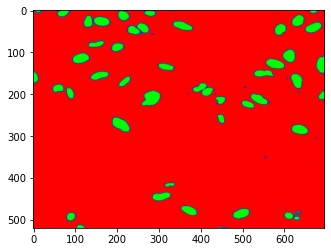

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


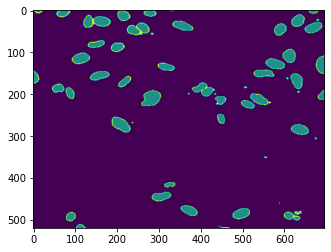

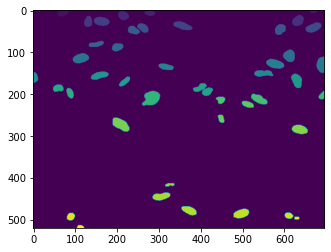

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_A01f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_A05f27d0.png


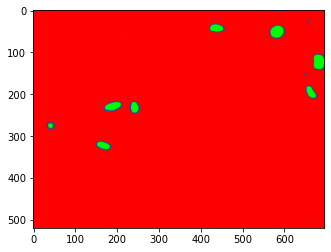

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


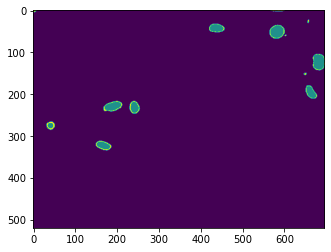

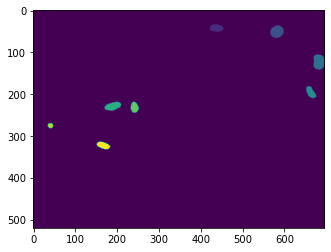

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_A05f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 8]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B18f27d0.png


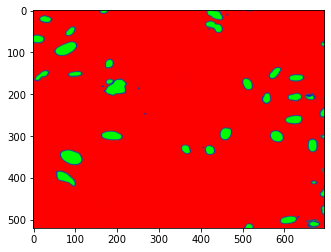

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


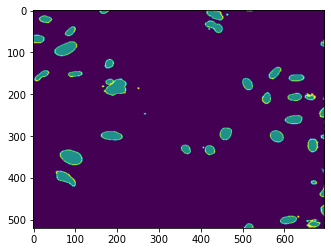

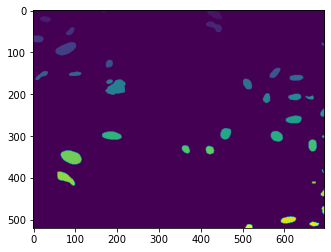

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_B18f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 37]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_B19f26d0.png


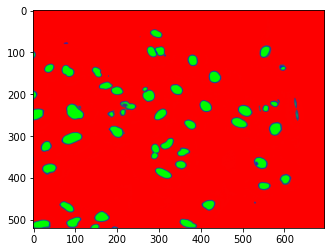

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


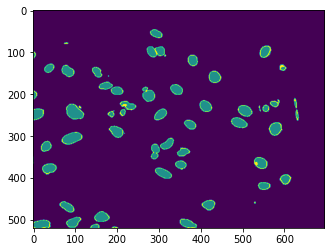

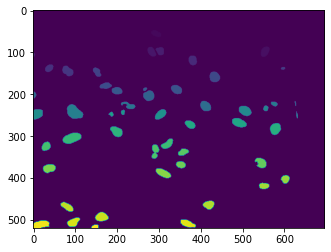

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_B19f26d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 51]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_D04f27d0.png


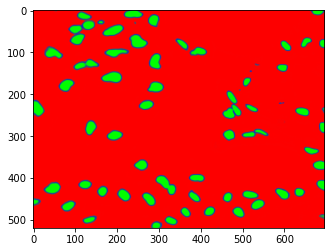

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


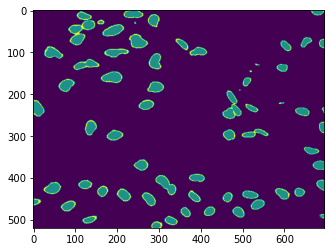

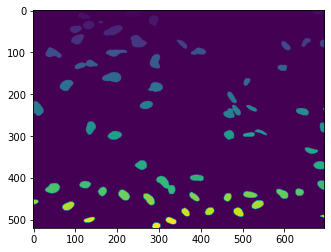

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_D04f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 63]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_I06f29d0.png


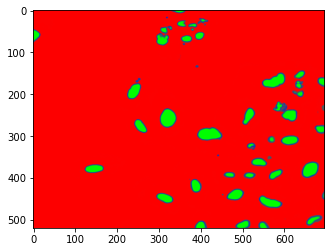

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


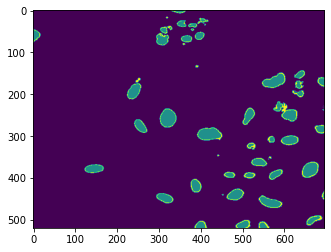

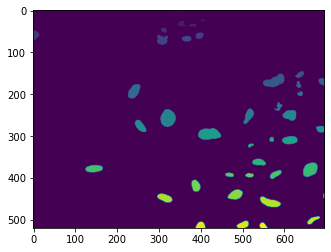

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_I06f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 40]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_I07f27d0.png


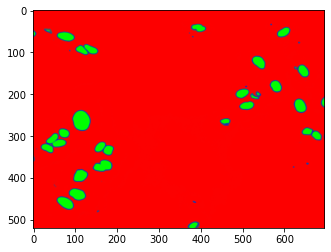

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


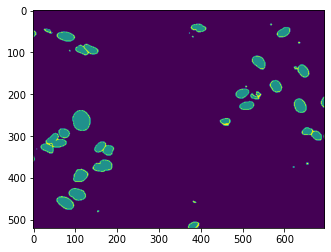

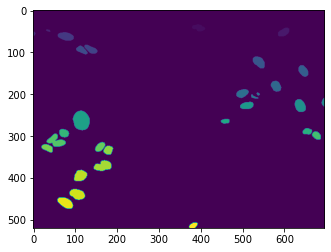

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_I07f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 30]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_J12f29d0.png


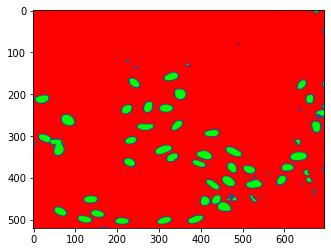

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


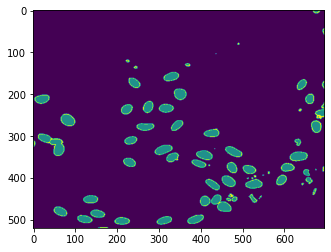

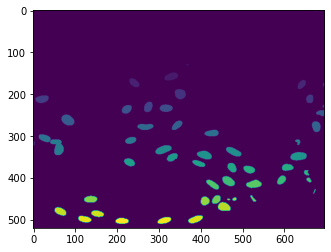

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_J12f29d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 55]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_L13f27d0.png


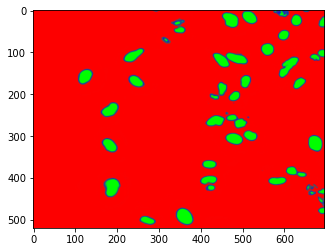

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


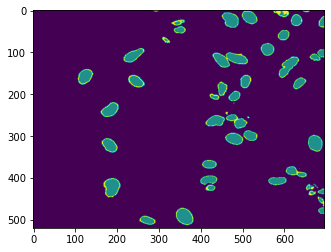

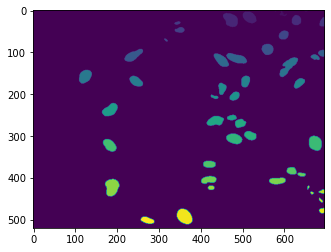

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_L13f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 47]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_L14f27d0.png


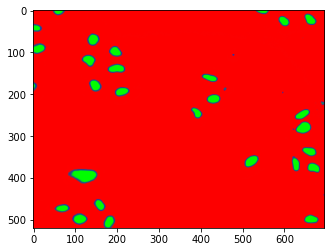

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


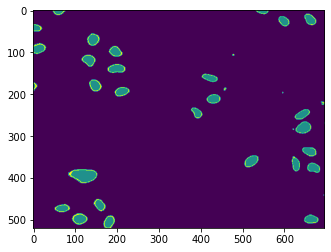

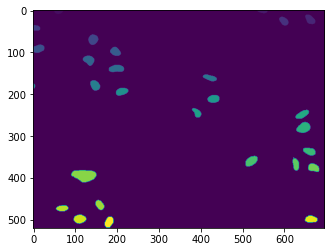

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_L14f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 28]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_O09f27d0.png


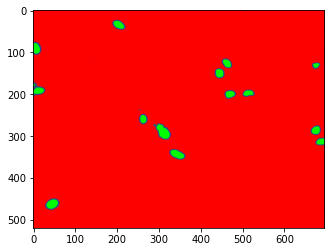

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


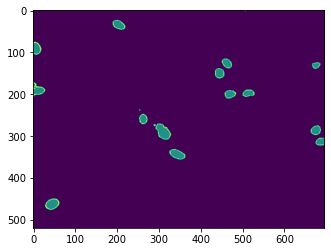

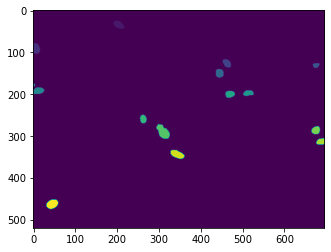

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_O09f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 15]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P09f27d0.png


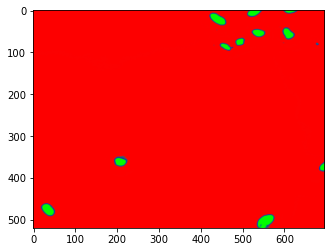

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


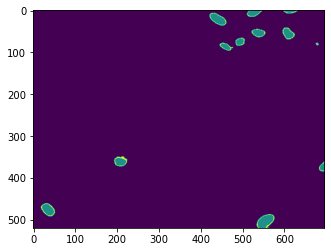

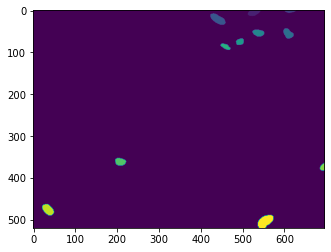

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_P09f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 11]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P17f28d0.png


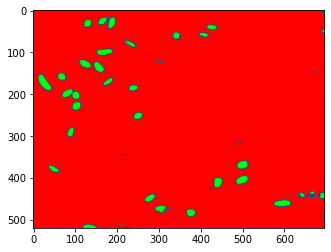

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


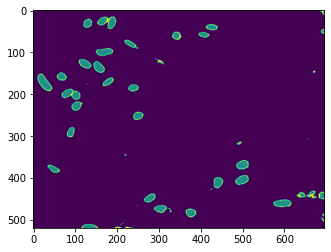

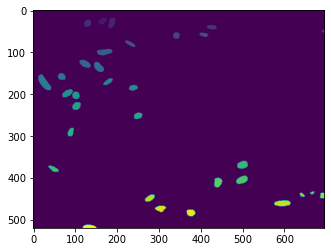

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_P17f28d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 33]. Convert image to uint8 prior to saving to suppress this warning.


MFGTMPcx7_170803210001_P22f27d0.png


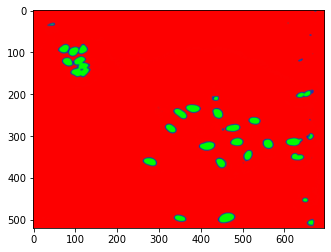

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


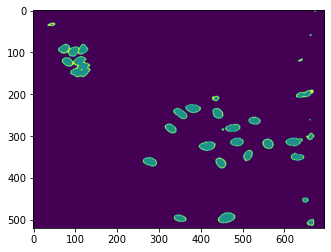

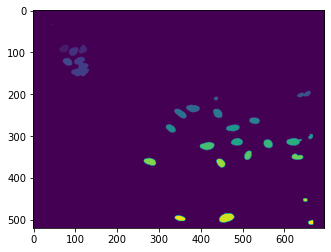

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: /home/jupyter/experiments/MA_3/out/segm/MFGTMPcx7_170803210001_P22f27d0.png is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 27]. Convert image to uint8 prior to saving to suppress this warning.


In [48]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

### evaluation

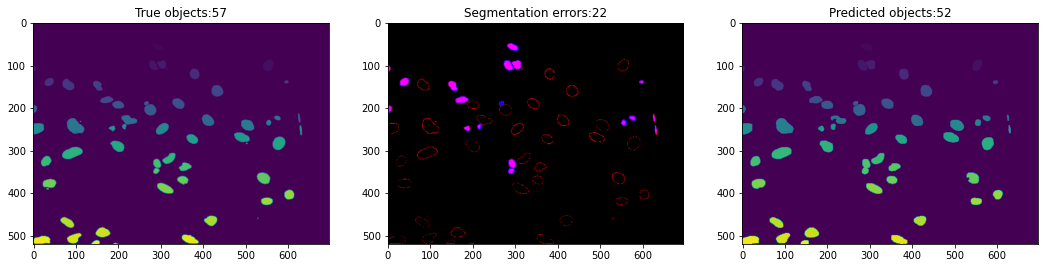

In [49]:
all_images = sorted(['MFGTMPcx7_170803210001_B19f26d0.png', 'MFGTMPcx7_170803210001_J12f29d0.png'])

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = skimage.io.imread(img_filename)
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

Threshold        F1   Jaccard
0       0.50  0.651090  0.506499
1       0.55  0.554677  0.506499
2       0.60  0.370397  0.506499
3       0.65  0.236600  0.506499
4       0.70  0.108954  0.506499
5       0.75  0.026440  0.506499
6       0.80  0.008547  0.506499
7       0.85  0.000000  0.506499
8       0.90  0.000000  0.506499
9       0.95  0.000000  0.506499

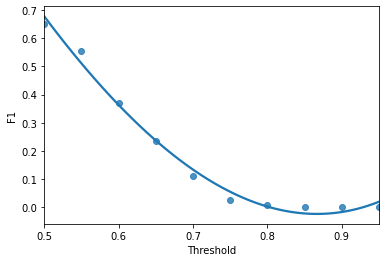

In [21]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [22]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      34.0
Small nuclei     66.0
Normal nuclei     7.0
Large nuclei      NaN
Name: False_Negative, dtype: float64

> 0-250 [pixels^2] = tiny
>
> 250-625 = small
>
> 625-900 = normal
>
> 900-10000 = large

In [23]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 93
